In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [9]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [10]:
OUTPUT_DIR = './pppm-mse-2/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun 10 11:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50
    epochs=4
    encoder_lr=1e-5 #2e-5
    decoder_lr=1e-5 #2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=14
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=20
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [13]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb') 
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-MSE-2', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [14]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.3
env: TOKENIZERS_PARALLELISM=true


# Utils

In [15]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [16]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [17]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
# cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [18]:
train['text'] = '[CLS]' + train['anchor'] + '[cpc]' + train['context_text'] + '[SEP]'  + train['target'] + '[SEP]'
test['text'] = '[CLS]' + test['anchor'] + '[cpc]' + test['context_text'] + '[SEP]'  + test['target'] + '[SEP]'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[cpc]HUMAN NECESSITIES. FURNITUR...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[cpc]HUMAN NECESSITIES. FURNITUR...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[cpc]HUMAN NECESSITIES. FURNITUR...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[cpc]HUMAN NECESSITIES. FURNITUR...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[cpc]HUMAN NECESSITIES. FURNITUR...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,[CLS]opc drum[cpc]PHYSICS. OPTICS[SEP]inorgani...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,[CLS]adjust gas flow[cpc]MECHANICAL ENGINEERIN...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,[CLS]lower trunnion[cpc]PERFORMING OPERATIONS;...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,[CLS]cap component[cpc]TEXTILES; PAPER. TREATM...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,[CLS]neural stimulation[cpc]ELECTRICITY. ELECT...


# EDA

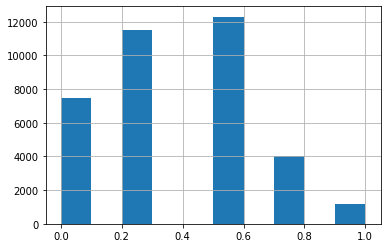

In [19]:
train['score'].hist()

In [20]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [21]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [22]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [23]:
# titles = pd.read_csv('./titles.csv')
# train = train.merge(titles, left_on='context', right_on='code')
# train['fold'] = -1
# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for f, (t_, v_) in enumerate(kf.split(X=train, y=train['anchor'], groups=train['anchor'])):
#     train.loc[v_, 'fold'] = f

# train['fold'].hist()
# train['text'] = train['anchor'] + '[SEP]' + train['title'].apply(str.lower)
# train = train[['id','anchor', 'target', 'context', 'score', 'title', 'fold', 'text']]

In [24]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

696 37
696 37
696 37
696 37
696 37
697 36
697 36
696 37
696 37
696 37
697 36
697 36
696 37
696 37
696 37
696 37
696 37
697 36
697 36
697 36
7     2026
15    2008
14    1989
9     1977
5     1976
0     1930
1     1917
16    1883
3     1820
2     1817
8     1809
18    1804
10    1788
4     1755
19    1750
12    1733
11    1728
17    1666
6     1655
13    1442
Name: fold, dtype: int64


In [25]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [26]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

# Dataset

In [27]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 117


In [28]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [29]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [30]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]

        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        
        out = sum_embeddings / sum_mask
        out = self.layer_norm1(out)
        output = self.fc(out)
        
        return output


# Helper Functions

In [31]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)


        labels = labels.to(torch.float16)
        # print(y_preds.view(-1, 1).dtype)
        # print(labels.view(-1, 1).dtype)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # print(loss.dtype)

        
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        labels = labels.to(torch.float16)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [32]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction="mean")
    # criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    try:
        predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                                map_location=torch.device('cpu'))['predictions']
        valid_folds['pred'] = predictions
    except:
        valid_folds['pred'] = -1

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2467] Elapsed 0m 0s (remain 29m 23s) Loss: 0.3369(0.3369) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2467] Elapsed 0m 18s (remain 7m 12s) Loss: 0.0653(0.1559) Grad: 29346.4980  LR: 0.00001000  
Epoch: [1][200/2467] Elapsed 0m 35s (remain 6m 45s) Loss: 0.0984(0.1243) Grad: 46337.9648  LR: 0.00000999  
Epoch: [1][300/2467] Elapsed 0m 53s (remain 6m 24s) Loss: 0.0373(0.1060) Grad: 17891.6406  LR: 0.00000998  
Epoch: [1][400/2467] Elapsed 1m 11s (remain 6m 5s) Loss: 0.1285(0.0983) Grad: 41816.4961  LR: 0.00000997  
Epoch: [1][500/2467] Elapsed 1m 28s (remain 5m 47s) Loss: 0.0497(0.0901) Grad: 11338.1436  LR: 0.00000995  
Epoch: [1][600/2467] Elapsed 1m 45s (remain 5m 28s) Loss: 0.0636(0.0837) Grad: 27190.1426  LR: 0.00000992  
Epoch: [1][700/2467] Elapsed 2m 2s (remain 5m 9s) Loss: 0.0242(0.0781) Grad: 4191.6753  LR: 0.00000989  
Epoch: [1][800/2467] Elapsed 2m 20s (remain 4m 51s) Loss: 0.0864(0.0730) Grad: 36242.5625  LR: 0.00000986  
Epoch: [1][900/2467] Elapsed 2m 37s (rema

Epoch 1 - avg_train_loss: 0.0459  avg_val_loss: 0.0921  time: 437s
Epoch 1 - Score: 0.8150
Epoch 1 - Save Best Score: 0.8150 Model


EVAL: [137/138] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0379(0.0921) 
Epoch: [2][0/2467] Elapsed 0m 0s (remain 17m 44s) Loss: 0.0134(0.0134) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2467] Elapsed 0m 17s (remain 6m 52s) Loss: 0.0377(0.0200) Grad: 12629.9990  LR: 0.00000846  
Epoch: [2][200/2467] Elapsed 0m 35s (remain 6m 36s) Loss: 0.0184(0.0197) Grad: 12748.1621  LR: 0.00000835  
Epoch: [2][300/2467] Elapsed 0m 52s (remain 6m 15s) Loss: 0.0123(0.0189) Grad: 12174.8066  LR: 0.00000823  
Epoch: [2][400/2467] Elapsed 1m 9s (remain 5m 56s) Loss: 0.0304(0.0189) Grad: 38169.9727  LR: 0.00000810  
Epoch: [2][500/2467] Elapsed 1m 26s (remain 5m 37s) Loss: 0.0149(0.0188) Grad: 11874.8867  LR: 0.00000797  
Epoch: [2][600/2467] Elapsed 1m 43s (remain 5m 19s) Loss: 0.0135(0.0187) Grad: 8309.2852  LR: 0.00000784  
Epoch: [2][700/2467] Elapsed 2m 0s (remain 5m 2s) Loss: 0.0245(0.0188) Grad: 71378.4609  LR: 0.00000771  
Epoch: [2][800/2467] Elapsed 2m 17s (remain 4m 45s) Loss: 0.0102(0.0189) Grad: 12

Epoch 2 - avg_train_loss: 0.0188  avg_val_loss: 0.0899  time: 434s
Epoch 2 - Score: 0.8232
Epoch 2 - Save Best Score: 0.8232 Model


EVAL: [137/138] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0415(0.0899) 
Epoch: [3][0/2467] Elapsed 0m 0s (remain 17m 40s) Loss: 0.0174(0.0174) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2467] Elapsed 0m 18s (remain 7m 4s) Loss: 0.0181(0.0161) Grad: 85813.7422  LR: 0.00000488  
Epoch: [3][200/2467] Elapsed 0m 35s (remain 6m 43s) Loss: 0.0077(0.0157) Grad: 49904.6523  LR: 0.00000472  
Epoch: [3][300/2467] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0089(0.0152) Grad: 26527.0176  LR: 0.00000456  
Epoch: [3][400/2467] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0087(0.0147) Grad: 34080.5000  LR: 0.00000440  
Epoch: [3][500/2467] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0152(0.0147) Grad: 14571.4385  LR: 0.00000424  
Epoch: [3][600/2467] Elapsed 1m 43s (remain 5m 21s) Loss: 0.0186(0.0148) Grad: 50236.8086  LR: 0.00000408  
Epoch: [3][700/2467] Elapsed 2m 0s (remain 5m 3s) Loss: 0.0054(0.0148) Grad: 16997.2148  LR: 0.00000393  
Epoch: [3][800/2467] Elapsed 2m 17s (remain 4m 45s) Loss: 0.0482(0.0150) Grad: 42

Epoch 3 - avg_train_loss: 0.0143  avg_val_loss: 0.0939  time: 431s
Epoch 3 - Score: 0.8235
Epoch 3 - Save Best Score: 0.8235 Model


EVAL: [137/138] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0419(0.0939) 
Epoch: [4][0/2467] Elapsed 0m 0s (remain 17m 40s) Loss: 0.0062(0.0062) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2467] Elapsed 0m 18s (remain 7m 1s) Loss: 0.0021(0.0112) Grad: 5516.6025  LR: 0.00000137  
Epoch: [4][200/2467] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0106(0.0112) Grad: 8384.3330  LR: 0.00000126  
Epoch: [4][300/2467] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0061(0.0111) Grad: 8057.0317  LR: 0.00000115  
Epoch: [4][400/2467] Elapsed 1m 9s (remain 5m 56s) Loss: 0.0150(0.0112) Grad: 51184.3594  LR: 0.00000105  
Epoch: [4][500/2467] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0142(0.0113) Grad: 89884.9219  LR: 0.00000096  
Epoch: [4][600/2467] Elapsed 1m 42s (remain 5m 18s) Loss: 0.0019(0.0112) Grad: 13858.8506  LR: 0.00000087  
Epoch: [4][700/2467] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0180(0.0113) Grad: 25881.6621  LR: 0.00000078  
Epoch: [4][800/2467] Elapsed 2m 15s (remain 4m 42s) Loss: 0.0063(0.0111) Grad: 1424

Epoch 4 - avg_train_loss: 0.0111  avg_val_loss: 0.0957  time: 429s
Epoch 4 - Score: 0.8271
Epoch 4 - Save Best Score: 0.8271 Model


EVAL: [137/138] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0429(0.0957) 


========== fold: 0 result ==========
Score: 0.8271
========== fold: 1 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2468] Elapsed 0m 0s (remain 18m 16s) Loss: 0.4866(0.4866) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2468] Elapsed 0m 18s (remain 7m 3s) Loss: 0.1897(0.1866) Grad: 70786.8828  LR: 0.00001000  
Epoch: [1][200/2468] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0879(0.1392) Grad: 41989.7305  LR: 0.00000999  
Epoch: [1][300/2468] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0917(0.1206) Grad: 38328.0469  LR: 0.00000998  
Epoch: [1][400/2468] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0584(0.1099) Grad: 25457.5840  LR: 0.00000997  
Epoch: [1][500/2468] Elapsed 1m 26s (remain 5m 38s) Loss: 0.0691(0.0998) Grad: 31686.6504  LR: 0.00000995  
Epoch: [1][600/2468] Elapsed 1m 43s (remain 5m 20s) Loss: 0.0320(0.0917) Grad: 6515.6138  LR: 0.00000992  
Epoch: [1][700/2468] Elapsed 2m 0s (remain 5m 2s) Loss: 0.1227(0.0853) Grad: 45427.8164  LR: 0.00000989  
Epoch: [1][800/2468] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0465(0.0805) Grad: 11749.8691  LR: 0.00000986  
Epoch: [1][900/2468] Elapsed 2m 33s (remai

Epoch 1 - avg_train_loss: 0.0495  avg_val_loss: 0.0953  time: 433s
Epoch 1 - Score: 0.8175
Epoch 1 - Save Best Score: 0.8175 Model


EVAL: [136/137] Elapsed 0m 12s (remain 0m 0s) Loss: 0.1176(0.0953) 
Epoch: [2][0/2468] Elapsed 0m 0s (remain 18m 55s) Loss: 0.0327(0.0327) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2468] Elapsed 0m 17s (remain 6m 54s) Loss: 0.0313(0.0206) Grad: 110699.5938  LR: 0.00000846  
Epoch: [2][200/2468] Elapsed 0m 35s (remain 6m 40s) Loss: 0.0023(0.0205) Grad: 14215.6367  LR: 0.00000835  
Epoch: [2][300/2468] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0410(0.0203) Grad: 44853.4297  LR: 0.00000823  
Epoch: [2][400/2468] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0101(0.0200) Grad: 21701.9961  LR: 0.00000810  
Epoch: [2][500/2468] Elapsed 1m 26s (remain 5m 38s) Loss: 0.0101(0.0195) Grad: 23480.8984  LR: 0.00000797  
Epoch: [2][600/2468] Elapsed 1m 43s (remain 5m 20s) Loss: 0.0144(0.0196) Grad: 27103.9395  LR: 0.00000784  
Epoch: [2][700/2468] Elapsed 2m 0s (remain 5m 2s) Loss: 0.0276(0.0196) Grad: 31372.5957  LR: 0.00000771  
Epoch: [2][800/2468] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0094(0.0195) Grad: 

Epoch 2 - avg_train_loss: 0.0193  avg_val_loss: 0.1012  time: 431s
Epoch 2 - Score: 0.8256
Epoch 2 - Save Best Score: 0.8256 Model


EVAL: [136/137] Elapsed 0m 12s (remain 0m 0s) Loss: 0.1183(0.1012) 
Epoch: [3][0/2468] Elapsed 0m 0s (remain 18m 14s) Loss: 0.0168(0.0168) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2468] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0064(0.0154) Grad: 42286.3516  LR: 0.00000488  
Epoch: [3][200/2468] Elapsed 0m 35s (remain 6m 37s) Loss: 0.0125(0.0161) Grad: 30331.1465  LR: 0.00000472  
Epoch: [3][300/2468] Elapsed 0m 52s (remain 6m 15s) Loss: 0.0236(0.0155) Grad: 48875.2539  LR: 0.00000456  
Epoch: [3][400/2468] Elapsed 1m 9s (remain 5m 55s) Loss: 0.0138(0.0151) Grad: 5171.1162  LR: 0.00000440  
Epoch: [3][500/2468] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0158(0.0151) Grad: 39342.9961  LR: 0.00000424  
Epoch: [3][600/2468] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0307(0.0152) Grad: 28180.3477  LR: 0.00000408  
Epoch: [3][700/2468] Elapsed 1m 59s (remain 5m 1s) Loss: 0.0063(0.0153) Grad: 2748.3635  LR: 0.00000393  
Epoch: [3][800/2468] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0174(0.0154) Grad: 15

Epoch 3 - avg_train_loss: 0.0149  avg_val_loss: 0.0974  time: 432s
Epoch 3 - Score: 0.8364
Epoch 3 - Save Best Score: 0.8364 Model


EVAL: [136/137] Elapsed 0m 12s (remain 0m 0s) Loss: 0.1187(0.0974) 
Epoch: [4][0/2468] Elapsed 0m 0s (remain 18m 40s) Loss: 0.0302(0.0302) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2468] Elapsed 0m 17s (remain 6m 53s) Loss: 0.0157(0.0122) Grad: 18134.4922  LR: 0.00000137  
Epoch: [4][200/2468] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0047(0.0122) Grad: 26813.6152  LR: 0.00000126  
Epoch: [4][300/2468] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0164(0.0122) Grad: 70857.6328  LR: 0.00000115  
Epoch: [4][400/2468] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0133(0.0120) Grad: 37960.8125  LR: 0.00000105  
Epoch: [4][500/2468] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0068(0.0120) Grad: 34848.0078  LR: 0.00000096  
Epoch: [4][600/2468] Elapsed 1m 43s (remain 5m 21s) Loss: 0.0176(0.0118) Grad: 42684.7109  LR: 0.00000087  
Epoch: [4][700/2468] Elapsed 2m 0s (remain 5m 3s) Loss: 0.0246(0.0118) Grad: 20787.7402  LR: 0.00000078  
Epoch: [4][800/2468] Elapsed 2m 17s (remain 4m 45s) Loss: 0.0061(0.0118) Grad: 1

Epoch 4 - avg_train_loss: 0.0115  avg_val_loss: 0.0956  time: 432s
Epoch 4 - Score: 0.8360


EVAL: [136/137] Elapsed 0m 12s (remain 0m 0s) Loss: 0.1143(0.0956) 


========== fold: 1 result ==========
Score: 0.8364
========== fold: 2 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2475] Elapsed 0m 0s (remain 17m 18s) Loss: 0.4033(0.4033) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2475] Elapsed 0m 17s (remain 6m 43s) Loss: 0.1312(0.1213) Grad: 33156.1055  LR: 0.00001000  
Epoch: [1][200/2475] Elapsed 0m 33s (remain 6m 24s) Loss: 0.0658(0.1068) Grad: 3392.5544  LR: 0.00000999  
Epoch: [1][300/2475] Elapsed 0m 50s (remain 6m 7s) Loss: 0.1044(0.1082) Grad: 41714.2695  LR: 0.00000998  
Epoch: [1][400/2475] Elapsed 1m 7s (remain 5m 50s) Loss: 0.0423(0.1007) Grad: 21420.7207  LR: 0.00000997  
Epoch: [1][500/2475] Elapsed 1m 24s (remain 5m 33s) Loss: 0.1632(0.0936) Grad: 56324.0820  LR: 0.00000995  
Epoch: [1][600/2475] Elapsed 1m 41s (remain 5m 15s) Loss: 0.0592(0.0889) Grad: 7015.4219  LR: 0.00000992  
Epoch: [1][700/2475] Elapsed 1m 57s (remain 4m 58s) Loss: 0.0529(0.0857) Grad: 6727.0342  LR: 0.00000989  
Epoch: [1][800/2475] Elapsed 2m 14s (remain 4m 41s) Loss: 0.0533(0.0813) Grad: 16802.6641  LR: 0.00000986  
Epoch: [1][900/2475] Elapsed 2m 31s (remai

Epoch 1 - avg_train_loss: 0.0497  avg_val_loss: 0.0996  time: 430s
Epoch 1 - Score: 0.8139
Epoch 1 - Save Best Score: 0.8139 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1007(0.0996) 
Epoch: [2][0/2475] Elapsed 0m 0s (remain 19m 3s) Loss: 0.0342(0.0342) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2475] Elapsed 0m 17s (remain 6m 59s) Loss: 0.0193(0.0193) Grad: 13125.5576  LR: 0.00000846  
Epoch: [2][200/2475] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0125(0.0200) Grad: 32555.5781  LR: 0.00000835  
Epoch: [2][300/2475] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0120(0.0200) Grad: 25186.5137  LR: 0.00000823  
Epoch: [2][400/2475] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0398(0.0197) Grad: 7484.0630  LR: 0.00000810  
Epoch: [2][500/2475] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0194(0.0200) Grad: 47424.9375  LR: 0.00000798  
Epoch: [2][600/2475] Elapsed 1m 43s (remain 5m 21s) Loss: 0.0077(0.0203) Grad: 12795.1055  LR: 0.00000785  
Epoch: [2][700/2475] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0055(0.0199) Grad: 24445.8398  LR: 0.00000771  
Epoch: [2][800/2475] Elapsed 2m 17s (remain 4m 46s) Loss: 0.0380(0.0199) Grad: 909

Epoch 2 - avg_train_loss: 0.0198  avg_val_loss: 0.0921  time: 432s
Epoch 2 - Score: 0.8297
Epoch 2 - Save Best Score: 0.8297 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0915(0.0921) 
Epoch: [3][0/2475] Elapsed 0m 0s (remain 18m 29s) Loss: 0.0251(0.0251) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2475] Elapsed 0m 17s (remain 6m 57s) Loss: 0.0090(0.0188) Grad: 18142.9082  LR: 0.00000488  
Epoch: [3][200/2475] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0122(0.0168) Grad: 22109.1367  LR: 0.00000472  
Epoch: [3][300/2475] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0074(0.0165) Grad: 16252.8770  LR: 0.00000456  
Epoch: [3][400/2475] Elapsed 1m 9s (remain 5m 59s) Loss: 0.0121(0.0159) Grad: 5638.9766  LR: 0.00000440  
Epoch: [3][500/2475] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0107(0.0157) Grad: 11030.0215  LR: 0.00000424  
Epoch: [3][600/2475] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0175(0.0158) Grad: 24809.9570  LR: 0.00000409  
Epoch: [3][700/2475] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0061(0.0158) Grad: 11132.5000  LR: 0.00000393  
Epoch: [3][800/2475] Elapsed 2m 17s (remain 4m 46s) Loss: 0.0228(0.0159) Grad: 23

Epoch 3 - avg_train_loss: 0.0151  avg_val_loss: 0.1016  time: 432s
Epoch 3 - Score: 0.8340
Epoch 3 - Save Best Score: 0.8340 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0962(0.1016) 
Epoch: [4][0/2475] Elapsed 0m 0s (remain 18m 59s) Loss: 0.0126(0.0126) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2475] Elapsed 0m 17s (remain 6m 58s) Loss: 0.0087(0.0113) Grad: 6581.4888  LR: 0.00000137  
Epoch: [4][200/2475] Elapsed 0m 35s (remain 6m 42s) Loss: 0.0137(0.0116) Grad: 81173.4219  LR: 0.00000126  
Epoch: [4][300/2475] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0053(0.0116) Grad: 21659.2305  LR: 0.00000116  
Epoch: [4][400/2475] Elapsed 1m 9s (remain 5m 59s) Loss: 0.0054(0.0118) Grad: 13235.9512  LR: 0.00000106  
Epoch: [4][500/2475] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0073(0.0119) Grad: 6266.9561  LR: 0.00000096  
Epoch: [4][600/2475] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0095(0.0120) Grad: 24340.3594  LR: 0.00000087  
Epoch: [4][700/2475] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0131(0.0120) Grad: 18697.5117  LR: 0.00000078  
Epoch: [4][800/2475] Elapsed 2m 17s (remain 4m 46s) Loss: 0.0137(0.0120) Grad: 270

Epoch 4 - avg_train_loss: 0.0115  avg_val_loss: 0.1000  time: 433s
Epoch 4 - Score: 0.8310


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0940(0.1000) 


========== fold: 2 result ==========
Score: 0.8340
========== fold: 3 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2475] Elapsed 0m 0s (remain 17m 9s) Loss: 0.4932(0.4932) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2475] Elapsed 0m 17s (remain 6m 48s) Loss: 0.0887(0.1672) Grad: 10361.1709  LR: 0.00001000  
Epoch: [1][200/2475] Elapsed 0m 34s (remain 6m 29s) Loss: 0.1078(0.1257) Grad: 13173.4043  LR: 0.00000999  
Epoch: [1][300/2475] Elapsed 0m 51s (remain 6m 11s) Loss: 0.0426(0.1150) Grad: 1327.6882  LR: 0.00000998  
Epoch: [1][400/2475] Elapsed 1m 8s (remain 5m 54s) Loss: 0.0560(0.1006) Grad: 11467.5645  LR: 0.00000997  
Epoch: [1][500/2475] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0664(0.0939) Grad: 12001.6895  LR: 0.00000995  
Epoch: [1][600/2475] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0248(0.0874) Grad: 4807.1094  LR: 0.00000992  
Epoch: [1][700/2475] Elapsed 1m 59s (remain 5m 2s) Loss: 0.0303(0.0810) Grad: 7932.2866  LR: 0.00000989  
Epoch: [1][800/2475] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0324(0.0764) Grad: 8856.5488  LR: 0.00000986  
Epoch: [1][900/2475] Elapsed 2m 33s (remain 

Epoch 1 - avg_train_loss: 0.0495  avg_val_loss: 0.0935  time: 433s
Epoch 1 - Score: 0.8099
Epoch 1 - Save Best Score: 0.8099 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0392(0.0935) 
Epoch: [2][0/2475] Elapsed 0m 0s (remain 18m 44s) Loss: 0.0343(0.0343) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2475] Elapsed 0m 17s (remain 7m 2s) Loss: 0.0320(0.0202) Grad: 17590.1914  LR: 0.00000846  
Epoch: [2][200/2475] Elapsed 0m 35s (remain 6m 42s) Loss: 0.0112(0.0188) Grad: 17133.8535  LR: 0.00000835  
Epoch: [2][300/2475] Elapsed 0m 52s (remain 6m 20s) Loss: 0.0181(0.0190) Grad: 8161.3652  LR: 0.00000823  
Epoch: [2][400/2475] Elapsed 1m 9s (remain 5m 59s) Loss: 0.0087(0.0188) Grad: 20105.3105  LR: 0.00000810  
Epoch: [2][500/2475] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0171(0.0192) Grad: 13850.3252  LR: 0.00000798  
Epoch: [2][600/2475] Elapsed 1m 43s (remain 5m 21s) Loss: 0.0220(0.0191) Grad: 12710.8682  LR: 0.00000785  
Epoch: [2][700/2475] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0262(0.0190) Grad: 112129.2656  LR: 0.00000771  
Epoch: [2][800/2475] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0317(0.0190) Grad: 1

Epoch 2 - avg_train_loss: 0.0183  avg_val_loss: 0.0922  time: 435s
Epoch 2 - Score: 0.8208
Epoch 2 - Save Best Score: 0.8208 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0398(0.0922) 
Epoch: [3][0/2475] Elapsed 0m 0s (remain 19m 5s) Loss: 0.0033(0.0033) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2475] Elapsed 0m 18s (remain 7m 7s) Loss: 0.0095(0.0159) Grad: 41383.3711  LR: 0.00000488  
Epoch: [3][200/2475] Elapsed 0m 36s (remain 6m 49s) Loss: 0.0260(0.0166) Grad: 97347.8047  LR: 0.00000472  
Epoch: [3][300/2475] Elapsed 0m 53s (remain 6m 24s) Loss: 0.0173(0.0168) Grad: 11166.2881  LR: 0.00000456  
Epoch: [3][400/2475] Elapsed 1m 10s (remain 6m 3s) Loss: 0.0258(0.0169) Grad: 21938.6484  LR: 0.00000440  
Epoch: [3][500/2475] Elapsed 1m 27s (remain 5m 44s) Loss: 0.0205(0.0166) Grad: 4303.3901  LR: 0.00000424  
Epoch: [3][600/2475] Elapsed 1m 44s (remain 5m 25s) Loss: 0.0102(0.0166) Grad: 26811.4180  LR: 0.00000409  
Epoch: [3][700/2475] Elapsed 2m 1s (remain 5m 7s) Loss: 0.0159(0.0165) Grad: 9797.6660  LR: 0.00000393  
Epoch: [3][800/2475] Elapsed 2m 18s (remain 4m 49s) Loss: 0.0102(0.0166) Grad: 5638.

Epoch 3 - avg_train_loss: 0.0165  avg_val_loss: 0.0962  time: 436s
Epoch 3 - Score: 0.8325
Epoch 3 - Save Best Score: 0.8325 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0403(0.0962) 
Epoch: [4][0/2475] Elapsed 0m 0s (remain 18m 36s) Loss: 0.0097(0.0097) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2475] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0120(0.0129) Grad: 16315.5410  LR: 0.00000137  
Epoch: [4][200/2475] Elapsed 0m 35s (remain 6m 40s) Loss: 0.0124(0.0132) Grad: 26557.7773  LR: 0.00000126  
Epoch: [4][300/2475] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0140(0.0136) Grad: 19436.5391  LR: 0.00000115  
Epoch: [4][400/2475] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0039(0.0138) Grad: 10215.3525  LR: 0.00000105  
Epoch: [4][500/2475] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0075(0.0138) Grad: 16977.3711  LR: 0.00000096  
Epoch: [4][600/2475] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0197(0.0136) Grad: 31016.6172  LR: 0.00000087  
Epoch: [4][700/2475] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0156(0.0137) Grad: 28110.7949  LR: 0.00000078  
Epoch: [4][800/2475] Elapsed 2m 17s (remain 4m 46s) Loss: 0.0100(0.0138) Grad: 3

Epoch 4 - avg_train_loss: 0.0133  avg_val_loss: 0.0963  time: 434s
Epoch 4 - Score: 0.8294


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0407(0.0963) 


========== fold: 3 result ==========
Score: 0.8325
========== fold: 4 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2479] Elapsed 0m 0s (remain 17m 20s) Loss: 0.2996(0.2996) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2479] Elapsed 0m 17s (remain 6m 47s) Loss: 0.0842(0.1401) Grad: 26828.1113  LR: 0.00001000  
Epoch: [1][200/2479] Elapsed 0m 34s (remain 6m 30s) Loss: 0.2323(0.1128) Grad: 80145.2891  LR: 0.00000999  
Epoch: [1][300/2479] Elapsed 0m 51s (remain 6m 11s) Loss: 0.0755(0.0972) Grad: 14664.4346  LR: 0.00000998  
Epoch: [1][400/2479] Elapsed 1m 8s (remain 5m 53s) Loss: 0.0468(0.0893) Grad: 8275.4727  LR: 0.00000997  
Epoch: [1][500/2479] Elapsed 1m 25s (remain 5m 36s) Loss: 0.0490(0.0850) Grad: 3128.3162  LR: 0.00000995  
Epoch: [1][600/2479] Elapsed 1m 42s (remain 5m 18s) Loss: 0.0574(0.0843) Grad: 19941.9199  LR: 0.00000992  
Epoch: [1][700/2479] Elapsed 1m 58s (remain 5m 1s) Loss: 0.0287(0.0790) Grad: 3973.5547  LR: 0.00000989  
Epoch: [1][800/2479] Elapsed 2m 15s (remain 4m 44s) Loss: 0.0536(0.0743) Grad: 20324.0723  LR: 0.00000986  
Epoch: [1][900/2479] Elapsed 2m 32s (remai

Epoch 1 - avg_train_loss: 0.0464  avg_val_loss: 0.1026  time: 430s
Epoch 1 - Score: 0.7996
Epoch 1 - Save Best Score: 0.7996 Model


EVAL: [125/126] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1175(0.1026) 
Epoch: [2][0/2479] Elapsed 0m 0s (remain 18m 27s) Loss: 0.0124(0.0124) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2479] Elapsed 0m 17s (remain 7m 0s) Loss: 0.0249(0.0221) Grad: 38447.6953  LR: 0.00000846  
Epoch: [2][200/2479] Elapsed 0m 35s (remain 6m 40s) Loss: 0.0204(0.0213) Grad: 5959.7061  LR: 0.00000835  
Epoch: [2][300/2479] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0334(0.0213) Grad: 74322.5547  LR: 0.00000823  
Epoch: [2][400/2479] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0254(0.0207) Grad: 6110.2764  LR: 0.00000810  
Epoch: [2][500/2479] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0132(0.0202) Grad: 36108.5859  LR: 0.00000798  
Epoch: [2][600/2479] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0115(0.0198) Grad: 20399.1484  LR: 0.00000785  
Epoch: [2][700/2479] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0514(0.0197) Grad: 75680.7188  LR: 0.00000772  
Epoch: [2][800/2479] Elapsed 2m 16s (remain 4m 46s) Loss: 0.0131(0.0197) Grad: 280

Epoch 2 - avg_train_loss: 0.0191  avg_val_loss: 0.0937  time: 434s
Epoch 2 - Score: 0.8085
Epoch 2 - Save Best Score: 0.8085 Model


EVAL: [125/126] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1137(0.0937) 
Epoch: [3][0/2479] Elapsed 0m 0s (remain 18m 50s) Loss: 0.0122(0.0122) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2479] Elapsed 0m 17s (remain 7m 3s) Loss: 0.0193(0.0151) Grad: 23803.7285  LR: 0.00000488  
Epoch: [3][200/2479] Elapsed 0m 35s (remain 6m 43s) Loss: 0.0137(0.0152) Grad: 8366.5186  LR: 0.00000472  
Epoch: [3][300/2479] Elapsed 0m 52s (remain 6m 20s) Loss: 0.0030(0.0151) Grad: 1970.0284  LR: 0.00000456  
Epoch: [3][400/2479] Elapsed 1m 9s (remain 6m 0s) Loss: 0.0068(0.0152) Grad: 25577.9180  LR: 0.00000441  
Epoch: [3][500/2479] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0096(0.0152) Grad: 36671.0820  LR: 0.00000425  
Epoch: [3][600/2479] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0148(0.0153) Grad: 45878.0703  LR: 0.00000409  
Epoch: [3][700/2479] Elapsed 1m 59s (remain 5m 4s) Loss: 0.0075(0.0151) Grad: 3679.9470  LR: 0.00000393  
Epoch: [3][800/2479] Elapsed 2m 16s (remain 4m 46s) Loss: 0.0095(0.0152) Grad: 29247

Epoch 3 - avg_train_loss: 0.0145  avg_val_loss: 0.0940  time: 433s
Epoch 3 - Score: 0.8170
Epoch 3 - Save Best Score: 0.8170 Model


EVAL: [125/126] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1083(0.0940) 
Epoch: [4][0/2479] Elapsed 0m 0s (remain 19m 10s) Loss: 0.0098(0.0098) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2479] Elapsed 0m 18s (remain 7m 6s) Loss: 0.0146(0.0108) Grad: 81231.5859  LR: 0.00000137  
Epoch: [4][200/2479] Elapsed 0m 35s (remain 6m 44s) Loss: 0.0112(0.0107) Grad: 27495.8691  LR: 0.00000126  
Epoch: [4][300/2479] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0068(0.0113) Grad: 5167.3081  LR: 0.00000116  
Epoch: [4][400/2479] Elapsed 1m 8s (remain 5m 57s) Loss: 0.0136(0.0114) Grad: 13986.5654  LR: 0.00000106  
Epoch: [4][500/2479] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0062(0.0116) Grad: 6092.0664  LR: 0.00000096  
Epoch: [4][600/2479] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0098(0.0115) Grad: 17846.2344  LR: 0.00000087  
Epoch: [4][700/2479] Elapsed 1m 58s (remain 5m 1s) Loss: 0.0050(0.0113) Grad: 19358.4629  LR: 0.00000078  
Epoch: [4][800/2479] Elapsed 2m 15s (remain 4m 43s) Loss: 0.0184(0.0111) Grad: 503

Epoch 4 - avg_train_loss: 0.0110  avg_val_loss: 0.0936  time: 427s
Epoch 4 - Score: 0.8168


EVAL: [125/126] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1099(0.0936) 


========== fold: 4 result ==========
Score: 0.8170
========== fold: 5 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2464] Elapsed 0m 0s (remain 16m 34s) Loss: 0.5322(0.5322) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2464] Elapsed 0m 16s (remain 6m 36s) Loss: 0.1451(0.1643) Grad: 38325.7500  LR: 0.00001000  
Epoch: [1][200/2464] Elapsed 0m 33s (remain 6m 18s) Loss: 0.0758(0.1278) Grad: 12284.4209  LR: 0.00000999  
Epoch: [1][300/2464] Elapsed 0m 50s (remain 6m 1s) Loss: 0.0698(0.1088) Grad: 24472.5000  LR: 0.00000998  
Epoch: [1][400/2464] Elapsed 1m 6s (remain 5m 44s) Loss: 0.0157(0.1022) Grad: 5507.6362  LR: 0.00000997  
Epoch: [1][500/2464] Elapsed 1m 23s (remain 5m 27s) Loss: 0.0283(0.0974) Grad: 10647.0469  LR: 0.00000995  
Epoch: [1][600/2464] Elapsed 1m 40s (remain 5m 10s) Loss: 0.0250(0.0894) Grad: 7101.6733  LR: 0.00000992  
Epoch: [1][700/2464] Elapsed 1m 56s (remain 4m 54s) Loss: 0.0365(0.0831) Grad: 5727.0435  LR: 0.00000989  
Epoch: [1][800/2464] Elapsed 2m 13s (remain 4m 37s) Loss: 0.0345(0.0788) Grad: 4568.5010  LR: 0.00000986  
Epoch: [1][900/2464] Elapsed 2m 30s (remain

Epoch 1 - avg_train_loss: 0.0497  avg_val_loss: 0.0924  time: 424s
Epoch 1 - Score: 0.7997
Epoch 1 - Save Best Score: 0.7997 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0575(0.0924) 
Epoch: [2][0/2464] Elapsed 0m 0s (remain 18m 18s) Loss: 0.0245(0.0245) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2464] Elapsed 0m 17s (remain 6m 44s) Loss: 0.0091(0.0205) Grad: 12446.3789  LR: 0.00000846  
Epoch: [2][200/2464] Elapsed 0m 34s (remain 6m 30s) Loss: 0.0313(0.0208) Grad: 39950.6016  LR: 0.00000835  
Epoch: [2][300/2464] Elapsed 0m 51s (remain 6m 9s) Loss: 0.0302(0.0204) Grad: 43099.5781  LR: 0.00000822  
Epoch: [2][400/2464] Elapsed 1m 8s (remain 5m 50s) Loss: 0.0239(0.0206) Grad: 32332.6914  LR: 0.00000810  
Epoch: [2][500/2464] Elapsed 1m 24s (remain 5m 32s) Loss: 0.0313(0.0204) Grad: 17253.7148  LR: 0.00000797  
Epoch: [2][600/2464] Elapsed 1m 41s (remain 5m 14s) Loss: 0.0183(0.0203) Grad: 47747.9102  LR: 0.00000784  
Epoch: [2][700/2464] Elapsed 1m 58s (remain 4m 57s) Loss: 0.0057(0.0199) Grad: 27005.3535  LR: 0.00000771  
Epoch: [2][800/2464] Elapsed 2m 15s (remain 4m 40s) Loss: 0.0172(0.0197) Grad: 

Epoch 2 - avg_train_loss: 0.0194  avg_val_loss: 0.1019  time: 427s
Epoch 2 - Score: 0.8102
Epoch 2 - Save Best Score: 0.8102 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0826(0.1019) 
Epoch: [3][0/2464] Elapsed 0m 0s (remain 18m 49s) Loss: 0.0307(0.0307) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2464] Elapsed 0m 17s (remain 6m 57s) Loss: 0.0107(0.0133) Grad: 37199.7539  LR: 0.00000488  
Epoch: [3][200/2464] Elapsed 0m 35s (remain 6m 38s) Loss: 0.0184(0.0139) Grad: 99210.8438  LR: 0.00000472  
Epoch: [3][300/2464] Elapsed 0m 52s (remain 6m 15s) Loss: 0.0105(0.0141) Grad: 28649.4512  LR: 0.00000456  
Epoch: [3][400/2464] Elapsed 1m 9s (remain 5m 55s) Loss: 0.0098(0.0139) Grad: 66358.5156  LR: 0.00000440  
Epoch: [3][500/2464] Elapsed 1m 25s (remain 5m 36s) Loss: 0.0233(0.0141) Grad: 93553.1172  LR: 0.00000424  
Epoch: [3][600/2464] Elapsed 1m 42s (remain 5m 17s) Loss: 0.0203(0.0145) Grad: 11259.9502  LR: 0.00000408  
Epoch: [3][700/2464] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0083(0.0143) Grad: 42784.5391  LR: 0.00000393  
Epoch: [3][800/2464] Elapsed 2m 16s (remain 4m 42s) Loss: 0.0120(0.0144) Grad: 

Epoch 3 - avg_train_loss: 0.0149  avg_val_loss: 0.1007  time: 429s
Epoch 3 - Score: 0.8163
Epoch 3 - Save Best Score: 0.8163 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0826(0.1007) 
Epoch: [4][0/2464] Elapsed 0m 0s (remain 18m 34s) Loss: 0.0060(0.0060) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2464] Elapsed 0m 17s (remain 6m 53s) Loss: 0.0109(0.0117) Grad: 51778.0859  LR: 0.00000137  
Epoch: [4][200/2464] Elapsed 0m 35s (remain 6m 34s) Loss: 0.0205(0.0115) Grad: 26762.0527  LR: 0.00000126  
Epoch: [4][300/2464] Elapsed 0m 51s (remain 6m 13s) Loss: 0.0076(0.0118) Grad: 44712.5547  LR: 0.00000115  
Epoch: [4][400/2464] Elapsed 1m 8s (remain 5m 53s) Loss: 0.0169(0.0117) Grad: 55635.9219  LR: 0.00000105  
Epoch: [4][500/2464] Elapsed 1m 25s (remain 5m 35s) Loss: 0.0059(0.0118) Grad: 12039.1934  LR: 0.00000096  
Epoch: [4][600/2464] Elapsed 1m 42s (remain 5m 17s) Loss: 0.0056(0.0119) Grad: 33844.2695  LR: 0.00000086  
Epoch: [4][700/2464] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0161(0.0120) Grad: 50661.4727  LR: 0.00000078  
Epoch: [4][800/2464] Elapsed 2m 16s (remain 4m 42s) Loss: 0.0089(0.0120) Grad: 

Epoch 4 - avg_train_loss: 0.0115  avg_val_loss: 0.0981  time: 429s
Epoch 4 - Score: 0.8184
Epoch 4 - Save Best Score: 0.8184 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0836(0.0981) 


========== fold: 5 result ==========
Score: 0.8184
========== fold: 6 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2487] Elapsed 0m 0s (remain 16m 53s) Loss: 1.0488(1.0488) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2487] Elapsed 0m 17s (remain 6m 54s) Loss: 0.0784(0.2316) Grad: 5161.5659  LR: 0.00001000  
Epoch: [1][200/2487] Elapsed 0m 34s (remain 6m 36s) Loss: 0.0992(0.1574) Grad: 11928.5713  LR: 0.00000999  
Epoch: [1][300/2487] Elapsed 0m 51s (remain 6m 14s) Loss: 0.0695(0.1364) Grad: 16460.9395  LR: 0.00000998  
Epoch: [1][400/2487] Elapsed 1m 8s (remain 5m 55s) Loss: 0.0306(0.1168) Grad: 2131.8782  LR: 0.00000997  
Epoch: [1][500/2487] Elapsed 1m 24s (remain 5m 36s) Loss: 0.0760(0.1037) Grad: 19490.9492  LR: 0.00000995  
Epoch: [1][600/2487] Elapsed 1m 41s (remain 5m 19s) Loss: 0.0478(0.0941) Grad: 3282.7717  LR: 0.00000992  
Epoch: [1][700/2487] Elapsed 1m 58s (remain 5m 1s) Loss: 0.0331(0.0865) Grad: 6913.5156  LR: 0.00000989  
Epoch: [1][800/2487] Elapsed 2m 15s (remain 4m 44s) Loss: 0.0439(0.0816) Grad: 7347.0386  LR: 0.00000986  
Epoch: [1][900/2487] Elapsed 2m 31s (remain 

Epoch 1 - avg_train_loss: 0.0482  avg_val_loss: 0.0932  time: 430s
Epoch 1 - Score: 0.8031
Epoch 1 - Save Best Score: 0.8031 Model


EVAL: [118/119] Elapsed 0m 10s (remain 0m 0s) Loss: 0.0778(0.0932) 
Epoch: [2][0/2487] Elapsed 0m 0s (remain 18m 58s) Loss: 0.0113(0.0113) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2487] Elapsed 0m 17s (remain 6m 55s) Loss: 0.0152(0.0180) Grad: 9996.1797  LR: 0.00000846  
Epoch: [2][200/2487] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0112(0.0176) Grad: 9240.5439  LR: 0.00000835  
Epoch: [2][300/2487] Elapsed 0m 51s (remain 6m 15s) Loss: 0.0193(0.0182) Grad: 34939.5195  LR: 0.00000823  
Epoch: [2][400/2487] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0200(0.0182) Grad: 20796.1680  LR: 0.00000811  
Epoch: [2][500/2487] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0135(0.0180) Grad: 22371.6230  LR: 0.00000798  
Epoch: [2][600/2487] Elapsed 1m 41s (remain 5m 19s) Loss: 0.0163(0.0179) Grad: 13394.2461  LR: 0.00000785  
Epoch: [2][700/2487] Elapsed 1m 58s (remain 5m 1s) Loss: 0.0161(0.0180) Grad: 46158.6250  LR: 0.00000772  
Epoch: [2][800/2487] Elapsed 2m 15s (remain 4m 44s) Loss: 0.0132(0.0179) Grad: 21

Epoch 2 - avg_train_loss: 0.0179  avg_val_loss: 0.0944  time: 428s
Epoch 2 - Score: 0.8102
Epoch 2 - Save Best Score: 0.8102 Model


EVAL: [118/119] Elapsed 0m 10s (remain 0m 0s) Loss: 0.0856(0.0944) 
Epoch: [3][0/2487] Elapsed 0m 0s (remain 18m 48s) Loss: 0.0166(0.0166) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2487] Elapsed 0m 17s (remain 6m 54s) Loss: 0.0129(0.0152) Grad: 7313.3062  LR: 0.00000488  
Epoch: [3][200/2487] Elapsed 0m 35s (remain 6m 38s) Loss: 0.0145(0.0140) Grad: 52503.1875  LR: 0.00000472  
Epoch: [3][300/2487] Elapsed 0m 51s (remain 6m 16s) Loss: 0.0172(0.0142) Grad: 45021.5547  LR: 0.00000456  
Epoch: [3][400/2487] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0184(0.0143) Grad: 34972.4258  LR: 0.00000440  
Epoch: [3][500/2487] Elapsed 1m 25s (remain 5m 38s) Loss: 0.0118(0.0147) Grad: 13519.0957  LR: 0.00000425  
Epoch: [3][600/2487] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0101(0.0144) Grad: 8045.9961  LR: 0.00000409  
Epoch: [3][700/2487] Elapsed 1m 58s (remain 5m 2s) Loss: 0.0118(0.0145) Grad: 5246.5420  LR: 0.00000394  
Epoch: [3][800/2487] Elapsed 2m 15s (remain 4m 45s) Loss: 0.0087(0.0147) Grad: 315

Epoch 3 - avg_train_loss: 0.0148  avg_val_loss: 0.1004  time: 429s
Epoch 3 - Score: 0.8160
Epoch 3 - Save Best Score: 0.8160 Model


EVAL: [118/119] Elapsed 0m 10s (remain 0m 0s) Loss: 0.0880(0.1004) 
Epoch: [4][0/2487] Elapsed 0m 0s (remain 19m 7s) Loss: 0.0232(0.0232) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2487] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0095(0.0132) Grad: 56274.6211  LR: 0.00000137  
Epoch: [4][200/2487] Elapsed 0m 34s (remain 6m 37s) Loss: 0.0059(0.0127) Grad: 26092.8555  LR: 0.00000126  
Epoch: [4][300/2487] Elapsed 0m 51s (remain 6m 15s) Loss: 0.0026(0.0122) Grad: 7142.0044  LR: 0.00000116  
Epoch: [4][400/2487] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0189(0.0121) Grad: 9441.3506  LR: 0.00000106  
Epoch: [4][500/2487] Elapsed 1m 25s (remain 5m 38s) Loss: 0.0169(0.0119) Grad: 48990.8086  LR: 0.00000096  
Epoch: [4][600/2487] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0080(0.0119) Grad: 11214.5195  LR: 0.00000087  
Epoch: [4][700/2487] Elapsed 1m 58s (remain 5m 3s) Loss: 0.0113(0.0119) Grad: 18599.5469  LR: 0.00000078  
Epoch: [4][800/2487] Elapsed 2m 15s (remain 4m 45s) Loss: 0.0030(0.0118) Grad: 208

Epoch 4 - avg_train_loss: 0.0118  avg_val_loss: 0.0959  time: 430s
Epoch 4 - Score: 0.8177
Epoch 4 - Save Best Score: 0.8177 Model


EVAL: [118/119] Elapsed 0m 10s (remain 0m 0s) Loss: 0.0869(0.0959) 


========== fold: 6 result ==========
Score: 0.8177
========== fold: 7 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2460] Elapsed 0m 0s (remain 17m 48s) Loss: 0.9204(0.9204) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2460] Elapsed 0m 17s (remain 6m 53s) Loss: 0.1111(0.2074) Grad: 3473.6072  LR: 0.00001000  
Epoch: [1][200/2460] Elapsed 0m 34s (remain 6m 29s) Loss: 0.0945(0.1458) Grad: 18031.6035  LR: 0.00000999  
Epoch: [1][300/2460] Elapsed 0m 51s (remain 6m 10s) Loss: 0.0627(0.1193) Grad: 9107.4434  LR: 0.00000998  
Epoch: [1][400/2460] Elapsed 1m 8s (remain 5m 51s) Loss: 0.0459(0.1051) Grad: 8082.3501  LR: 0.00000997  
Epoch: [1][500/2460] Elapsed 1m 25s (remain 5m 33s) Loss: 0.0255(0.0989) Grad: 7591.3550  LR: 0.00000995  
Epoch: [1][600/2460] Elapsed 1m 42s (remain 5m 16s) Loss: 0.0215(0.0893) Grad: 3194.4524  LR: 0.00000992  
Epoch: [1][700/2460] Elapsed 1m 59s (remain 4m 58s) Loss: 0.0467(0.0834) Grad: 5682.5562  LR: 0.00000989  
Epoch: [1][800/2460] Elapsed 2m 15s (remain 4m 41s) Loss: 0.0198(0.0787) Grad: 1575.6920  LR: 0.00000986  
Epoch: [1][900/2460] Elapsed 2m 32s (remain 4

Epoch 1 - avg_train_loss: 0.0470  avg_val_loss: 0.1024  time: 427s
Epoch 1 - Score: 0.7757
Epoch 1 - Save Best Score: 0.7757 Model


EVAL: [144/145] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0884(0.1024) 
Epoch: [2][0/2460] Elapsed 0m 0s (remain 18m 30s) Loss: 0.0405(0.0405) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2460] Elapsed 0m 17s (remain 6m 54s) Loss: 0.0111(0.0188) Grad: 39209.8125  LR: 0.00000846  
Epoch: [2][200/2460] Elapsed 0m 35s (remain 6m 33s) Loss: 0.0112(0.0184) Grad: 9047.1104  LR: 0.00000835  
Epoch: [2][300/2460] Elapsed 0m 51s (remain 6m 12s) Loss: 0.0109(0.0182) Grad: 53223.1289  LR: 0.00000822  
Epoch: [2][400/2460] Elapsed 1m 8s (remain 5m 52s) Loss: 0.0126(0.0177) Grad: 23014.7520  LR: 0.00000810  
Epoch: [2][500/2460] Elapsed 1m 25s (remain 5m 34s) Loss: 0.0077(0.0176) Grad: 16331.1328  LR: 0.00000797  
Epoch: [2][600/2460] Elapsed 1m 42s (remain 5m 16s) Loss: 0.0278(0.0177) Grad: 91619.8906  LR: 0.00000784  
Epoch: [2][700/2460] Elapsed 1m 59s (remain 4m 58s) Loss: 0.0293(0.0178) Grad: 71497.1328  LR: 0.00000771  
Epoch: [2][800/2460] Elapsed 2m 15s (remain 4m 41s) Loss: 0.0155(0.0179) Grad: 

Epoch 2 - avg_train_loss: 0.0177  avg_val_loss: 0.0962  time: 428s
Epoch 2 - Score: 0.8114
Epoch 2 - Save Best Score: 0.8114 Model


EVAL: [144/145] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0819(0.0962) 
Epoch: [3][0/2460] Elapsed 0m 0s (remain 18m 47s) Loss: 0.0204(0.0204) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2460] Elapsed 0m 17s (remain 6m 53s) Loss: 0.0248(0.0139) Grad: 17492.4023  LR: 0.00000488  
Epoch: [3][200/2460] Elapsed 0m 35s (remain 6m 34s) Loss: 0.0310(0.0145) Grad: 50368.4648  LR: 0.00000472  
Epoch: [3][300/2460] Elapsed 0m 51s (remain 6m 11s) Loss: 0.0154(0.0148) Grad: 36440.6992  LR: 0.00000456  
Epoch: [3][400/2460] Elapsed 1m 8s (remain 5m 52s) Loss: 0.0066(0.0149) Grad: 12165.9521  LR: 0.00000440  
Epoch: [3][500/2460] Elapsed 1m 25s (remain 5m 33s) Loss: 0.0105(0.0146) Grad: 19896.7090  LR: 0.00000424  
Epoch: [3][600/2460] Elapsed 1m 42s (remain 5m 16s) Loss: 0.0107(0.0149) Grad: 11519.8389  LR: 0.00000408  
Epoch: [3][700/2460] Elapsed 1m 59s (remain 4m 58s) Loss: 0.0115(0.0150) Grad: 21670.0156  LR: 0.00000393  
Epoch: [3][800/2460] Elapsed 2m 15s (remain 4m 41s) Loss: 0.0161(0.0150) Grad:

Epoch 3 - avg_train_loss: 0.0148  avg_val_loss: 0.1003  time: 430s
Epoch 3 - Score: 0.8058


EVAL: [144/145] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0832(0.1003) 
Epoch: [4][0/2460] Elapsed 0m 0s (remain 18m 38s) Loss: 0.0050(0.0050) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2460] Elapsed 0m 17s (remain 6m 44s) Loss: 0.0073(0.0117) Grad: 12012.4004  LR: 0.00000137  
Epoch: [4][200/2460] Elapsed 0m 34s (remain 6m 23s) Loss: 0.0229(0.0117) Grad: 22221.4707  LR: 0.00000126  
Epoch: [4][300/2460] Elapsed 0m 51s (remain 6m 5s) Loss: 0.0146(0.0121) Grad: 24712.0254  LR: 0.00000115  
Epoch: [4][400/2460] Elapsed 1m 7s (remain 5m 48s) Loss: 0.0072(0.0121) Grad: 9834.5410  LR: 0.00000105  
Epoch: [4][500/2460] Elapsed 1m 24s (remain 5m 31s) Loss: 0.0241(0.0120) Grad: 97651.6406  LR: 0.00000096  
Epoch: [4][600/2460] Elapsed 1m 41s (remain 5m 14s) Loss: 0.0172(0.0119) Grad: 28475.4648  LR: 0.00000087  
Epoch: [4][700/2460] Elapsed 1m 58s (remain 4m 58s) Loss: 0.0108(0.0119) Grad: 7587.1914  LR: 0.00000078  
Epoch: [4][800/2460] Elapsed 2m 15s (remain 4m 41s) Loss: 0.0036(0.0119) Grad: 81

Epoch 4 - avg_train_loss: 0.0119  avg_val_loss: 0.0984  time: 431s
Epoch 4 - Score: 0.8062


EVAL: [144/145] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0824(0.0984) 


========== fold: 7 result ==========
Score: 0.8114
========== fold: 8 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2476] Elapsed 0m 0s (remain 17m 7s) Loss: 1.3984(1.3984) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2476] Elapsed 0m 17s (remain 6m 41s) Loss: 0.1320(0.2153) Grad: 21810.0684  LR: 0.00001000  
Epoch: [1][200/2476] Elapsed 0m 33s (remain 6m 23s) Loss: 0.0612(0.1435) Grad: 12821.5635  LR: 0.00000999  
Epoch: [1][300/2476] Elapsed 0m 50s (remain 6m 6s) Loss: 0.0582(0.1178) Grad: 15317.2705  LR: 0.00000998  
Epoch: [1][400/2476] Elapsed 1m 7s (remain 5m 49s) Loss: 0.0788(0.1038) Grad: 7667.6592  LR: 0.00000997  
Epoch: [1][500/2476] Elapsed 1m 24s (remain 5m 33s) Loss: 0.1096(0.0981) Grad: 13513.6113  LR: 0.00000995  
Epoch: [1][600/2476] Elapsed 1m 41s (remain 5m 16s) Loss: 0.0437(0.0907) Grad: 11697.7422  LR: 0.00000992  
Epoch: [1][700/2476] Elapsed 1m 58s (remain 4m 59s) Loss: 0.0384(0.0842) Grad: 5757.8516  LR: 0.00000989  
Epoch: [1][800/2476] Elapsed 2m 15s (remain 4m 43s) Loss: 0.0447(0.0792) Grad: 4528.8467  LR: 0.00000986  
Epoch: [1][900/2476] Elapsed 2m 32s (remain

Epoch 1 - avg_train_loss: 0.0478  avg_val_loss: 0.1042  time: 431s
Epoch 1 - Score: 0.8149
Epoch 1 - Save Best Score: 0.8149 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1186(0.1042) 
Epoch: [2][0/2476] Elapsed 0m 0s (remain 18m 26s) Loss: 0.0159(0.0159) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2476] Elapsed 0m 17s (remain 6m 53s) Loss: 0.0219(0.0189) Grad: 17839.5059  LR: 0.00000846  
Epoch: [2][200/2476] Elapsed 0m 35s (remain 6m 36s) Loss: 0.0213(0.0184) Grad: 14604.5742  LR: 0.00000835  
Epoch: [2][300/2476] Elapsed 0m 51s (remain 6m 15s) Loss: 0.0155(0.0188) Grad: 3902.7712  LR: 0.00000823  
Epoch: [2][400/2476] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0149(0.0186) Grad: 14500.1895  LR: 0.00000810  
Epoch: [2][500/2476] Elapsed 1m 25s (remain 5m 38s) Loss: 0.0170(0.0184) Grad: 6839.6221  LR: 0.00000798  
Epoch: [2][600/2476] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0079(0.0183) Grad: 32352.0215  LR: 0.00000785  
Epoch: [2][700/2476] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0205(0.0181) Grad: 26511.8516  LR: 0.00000771  
Epoch: [2][800/2476] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0220(0.0182) Grad: 11

Epoch 2 - avg_train_loss: 0.0180  avg_val_loss: 0.0953  time: 432s
Epoch 2 - Score: 0.8409
Epoch 2 - Save Best Score: 0.8409 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1135(0.0953) 
Epoch: [3][0/2476] Elapsed 0m 0s (remain 18m 16s) Loss: 0.0210(0.0210) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2476] Elapsed 0m 17s (remain 7m 0s) Loss: 0.0067(0.0121) Grad: 21037.6426  LR: 0.00000488  
Epoch: [3][200/2476] Elapsed 0m 35s (remain 6m 42s) Loss: 0.0129(0.0133) Grad: 16688.9062  LR: 0.00000472  
Epoch: [3][300/2476] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0072(0.0135) Grad: 42704.3555  LR: 0.00000456  
Epoch: [3][400/2476] Elapsed 1m 9s (remain 5m 59s) Loss: 0.0084(0.0138) Grad: 57510.3477  LR: 0.00000440  
Epoch: [3][500/2476] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0186(0.0139) Grad: 40827.3555  LR: 0.00000424  
Epoch: [3][600/2476] Elapsed 1m 43s (remain 5m 21s) Loss: 0.0109(0.0140) Grad: 8945.3340  LR: 0.00000409  
Epoch: [3][700/2476] Elapsed 2m 0s (remain 5m 3s) Loss: 0.0065(0.0141) Grad: 7164.5513  LR: 0.00000393  
Epoch: [3][800/2476] Elapsed 2m 17s (remain 4m 46s) Loss: 0.0163(0.0145) Grad: 4134

Epoch 3 - avg_train_loss: 0.0148  avg_val_loss: 0.0944  time: 432s
Epoch 3 - Score: 0.8420
Epoch 3 - Save Best Score: 0.8420 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1113(0.0944) 
Epoch: [4][0/2476] Elapsed 0m 0s (remain 18m 7s) Loss: 0.0270(0.0270) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2476] Elapsed 0m 18s (remain 7m 4s) Loss: 0.0172(0.0114) Grad: 46398.8906  LR: 0.00000137  
Epoch: [4][200/2476] Elapsed 0m 35s (remain 6m 44s) Loss: 0.0098(0.0119) Grad: 22627.0859  LR: 0.00000126  
Epoch: [4][300/2476] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0056(0.0119) Grad: 24622.9414  LR: 0.00000115  
Epoch: [4][400/2476] Elapsed 1m 9s (remain 5m 59s) Loss: 0.0212(0.0120) Grad: 25831.2695  LR: 0.00000105  
Epoch: [4][500/2476] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0277(0.0122) Grad: 60944.2969  LR: 0.00000096  
Epoch: [4][600/2476] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0208(0.0120) Grad: 13513.9717  LR: 0.00000087  
Epoch: [4][700/2476] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0094(0.0120) Grad: 37414.8477  LR: 0.00000078  
Epoch: [4][800/2476] Elapsed 2m 17s (remain 4m 46s) Loss: 0.0077(0.0120) Grad: 100

Epoch 4 - avg_train_loss: 0.0119  avg_val_loss: 0.0953  time: 434s
Epoch 4 - Score: 0.8424
Epoch 4 - Save Best Score: 0.8424 Model


EVAL: [129/130] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1130(0.0953) 


========== fold: 8 result ==========
Score: 0.8424
========== fold: 9 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2464] Elapsed 0m 0s (remain 17m 56s) Loss: 0.7202(0.7202) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2464] Elapsed 0m 18s (remain 7m 4s) Loss: 0.0731(0.1695) Grad: 11618.2490  LR: 0.00001000  
Epoch: [1][200/2464] Elapsed 0m 35s (remain 6m 38s) Loss: 0.1537(0.1323) Grad: 46084.6758  LR: 0.00000999  
Epoch: [1][300/2464] Elapsed 0m 52s (remain 6m 16s) Loss: 0.0298(0.1107) Grad: 4894.6206  LR: 0.00000998  
Epoch: [1][400/2464] Elapsed 1m 9s (remain 5m 56s) Loss: 0.0415(0.1019) Grad: 19686.0312  LR: 0.00000997  
Epoch: [1][500/2464] Elapsed 1m 26s (remain 5m 38s) Loss: 0.0261(0.0947) Grad: 2066.7390  LR: 0.00000995  
Epoch: [1][600/2464] Elapsed 1m 43s (remain 5m 20s) Loss: 0.0237(0.0882) Grad: 18857.2832  LR: 0.00000992  
Epoch: [1][700/2464] Elapsed 2m 0s (remain 5m 3s) Loss: 0.0290(0.0825) Grad: 13246.7744  LR: 0.00000989  
Epoch: [1][800/2464] Elapsed 2m 17s (remain 4m 45s) Loss: 0.0232(0.0786) Grad: 7757.1074  LR: 0.00000986  
Epoch: [1][900/2464] Elapsed 2m 34s (remain 

Epoch 1 - avg_train_loss: 0.0477  avg_val_loss: 0.0975  time: 432s
Epoch 1 - Score: 0.7841
Epoch 1 - Save Best Score: 0.7841 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2251(0.0975) 
Epoch: [2][0/2464] Elapsed 0m 0s (remain 19m 25s) Loss: 0.0191(0.0191) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2464] Elapsed 0m 18s (remain 7m 1s) Loss: 0.0450(0.0206) Grad: 32987.9336  LR: 0.00000846  
Epoch: [2][200/2464] Elapsed 0m 35s (remain 6m 43s) Loss: 0.0285(0.0198) Grad: 12141.6113  LR: 0.00000835  
Epoch: [2][300/2464] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0179(0.0197) Grad: 22615.6035  LR: 0.00000822  
Epoch: [2][400/2464] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0326(0.0198) Grad: 67814.5469  LR: 0.00000810  
Epoch: [2][500/2464] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0110(0.0197) Grad: 6177.5239  LR: 0.00000797  
Epoch: [2][600/2464] Elapsed 1m 43s (remain 5m 20s) Loss: 0.0139(0.0197) Grad: 10810.8584  LR: 0.00000784  
Epoch: [2][700/2464] Elapsed 2m 0s (remain 5m 2s) Loss: 0.0075(0.0194) Grad: 6308.5352  LR: 0.00000771  
Epoch: [2][800/2464] Elapsed 2m 17s (remain 4m 44s) Loss: 0.0257(0.0194) Grad: 4041

Epoch 2 - avg_train_loss: 0.0192  avg_val_loss: 0.1006  time: 432s
Epoch 2 - Score: 0.8073
Epoch 2 - Save Best Score: 0.8073 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2144(0.1006) 
Epoch: [3][0/2464] Elapsed 0m 0s (remain 20m 33s) Loss: 0.0119(0.0119) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2464] Elapsed 0m 17s (remain 6m 54s) Loss: 0.0040(0.0152) Grad: 34437.1211  LR: 0.00000488  
Epoch: [3][200/2464] Elapsed 0m 34s (remain 6m 33s) Loss: 0.0245(0.0146) Grad: 17145.4219  LR: 0.00000472  
Epoch: [3][300/2464] Elapsed 0m 51s (remain 6m 12s) Loss: 0.0201(0.0146) Grad: 99388.8828  LR: 0.00000456  
Epoch: [3][400/2464] Elapsed 1m 8s (remain 5m 53s) Loss: 0.0047(0.0146) Grad: 26460.2617  LR: 0.00000440  
Epoch: [3][500/2464] Elapsed 1m 25s (remain 5m 36s) Loss: 0.0152(0.0146) Grad: 39193.8555  LR: 0.00000424  
Epoch: [3][600/2464] Elapsed 1m 42s (remain 5m 18s) Loss: 0.0212(0.0148) Grad: 49620.4688  LR: 0.00000408  
Epoch: [3][700/2464] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0080(0.0151) Grad: 14058.9941  LR: 0.00000393  
Epoch: [3][800/2464] Elapsed 2m 16s (remain 4m 43s) Loss: 0.0076(0.0150) Grad: 

Epoch 3 - avg_train_loss: 0.0150  avg_val_loss: 0.0988  time: 431s
Epoch 3 - Score: 0.8116
Epoch 3 - Save Best Score: 0.8116 Model


EVAL: [141/142] Elapsed 0m 13s (remain 0m 0s) Loss: 0.2085(0.0988) 
Epoch: [4][0/2464] Elapsed 0m 0s (remain 19m 21s) Loss: 0.0058(0.0058) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2464] Elapsed 0m 17s (remain 6m 58s) Loss: 0.0185(0.0114) Grad: 42406.7344  LR: 0.00000137  
Epoch: [4][200/2464] Elapsed 0m 35s (remain 6m 38s) Loss: 0.0171(0.0113) Grad: 69650.0156  LR: 0.00000126  
Epoch: [4][300/2464] Elapsed 0m 52s (remain 6m 15s) Loss: 0.0070(0.0110) Grad: 19285.1582  LR: 0.00000115  
Epoch: [4][400/2464] Elapsed 1m 9s (remain 5m 55s) Loss: 0.0120(0.0113) Grad: 27725.9414  LR: 0.00000105  
Epoch: [4][500/2464] Elapsed 1m 26s (remain 5m 37s) Loss: 0.0084(0.0114) Grad: 22870.0176  LR: 0.00000096  
Epoch: [4][600/2464] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0156(0.0114) Grad: 5238.3271  LR: 0.00000086  
Epoch: [4][700/2464] Elapsed 1m 59s (remain 5m 1s) Loss: 0.0070(0.0114) Grad: 25208.2773  LR: 0.00000078  
Epoch: [4][800/2464] Elapsed 2m 16s (remain 4m 43s) Loss: 0.0114(0.0114) Grad: 3

Epoch 4 - avg_train_loss: 0.0114  avg_val_loss: 0.0971  time: 433s
Epoch 4 - Score: 0.8128
Epoch 4 - Save Best Score: 0.8128 Model


EVAL: [141/142] Elapsed 0m 12s (remain 0m 0s) Loss: 0.2049(0.0971) 


========== fold: 9 result ==========
Score: 0.8128
========== fold: 10 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2477] Elapsed 0m 0s (remain 18m 13s) Loss: 0.6816(0.6816) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2477] Elapsed 0m 17s (remain 6m 59s) Loss: 0.1788(0.1807) Grad: 58579.1250  LR: 0.00001000  
Epoch: [1][200/2477] Elapsed 0m 34s (remain 6m 33s) Loss: 0.0578(0.1307) Grad: 9448.0820  LR: 0.00000999  
Epoch: [1][300/2477] Elapsed 0m 51s (remain 6m 12s) Loss: 0.0508(0.1168) Grad: 29797.6016  LR: 0.00000998  
Epoch: [1][400/2477] Elapsed 1m 8s (remain 5m 54s) Loss: 0.0249(0.1029) Grad: 11940.6602  LR: 0.00000997  
Epoch: [1][500/2477] Elapsed 1m 25s (remain 5m 36s) Loss: 0.1914(0.0935) Grad: 68419.6250  LR: 0.00000995  
Epoch: [1][600/2477] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0454(0.0860) Grad: 8189.8521  LR: 0.00000992  
Epoch: [1][700/2477] Elapsed 1m 59s (remain 5m 1s) Loss: 0.0183(0.0808) Grad: 7037.7075  LR: 0.00000989  
Epoch: [1][800/2477] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0349(0.0754) Grad: 9889.8574  LR: 0.00000986  
Epoch: [1][900/2477] Elapsed 2m 32s (remain

Epoch 1 - avg_train_loss: 0.0481  avg_val_loss: 0.1124  time: 433s
Epoch 1 - Score: 0.8283
Epoch 1 - Save Best Score: 0.8283 Model


EVAL: [127/128] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0089(0.1124) 
Epoch: [2][0/2477] Elapsed 0m 0s (remain 19m 22s) Loss: 0.0185(0.0185) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2477] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0093(0.0228) Grad: 20379.5918  LR: 0.00000846  
Epoch: [2][200/2477] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0096(0.0207) Grad: 16007.8213  LR: 0.00000835  
Epoch: [2][300/2477] Elapsed 0m 52s (remain 6m 20s) Loss: 0.0150(0.0196) Grad: 20776.7246  LR: 0.00000823  
Epoch: [2][400/2477] Elapsed 1m 9s (remain 6m 1s) Loss: 0.0146(0.0196) Grad: 29500.2578  LR: 0.00000810  
Epoch: [2][500/2477] Elapsed 1m 26s (remain 5m 42s) Loss: 0.0167(0.0192) Grad: 40157.7305  LR: 0.00000798  
Epoch: [2][600/2477] Elapsed 1m 43s (remain 5m 24s) Loss: 0.0184(0.0193) Grad: 9109.0713  LR: 0.00000785  
Epoch: [2][700/2477] Elapsed 2m 1s (remain 5m 6s) Loss: 0.0075(0.0195) Grad: 26374.2207  LR: 0.00000772  
Epoch: [2][800/2477] Elapsed 2m 18s (remain 4m 48s) Loss: 0.0223(0.0195) Grad: 510

Epoch 2 - avg_train_loss: 0.0188  avg_val_loss: 0.1042  time: 436s
Epoch 2 - Score: 0.8420
Epoch 2 - Save Best Score: 0.8420 Model


EVAL: [127/128] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0082(0.1042) 
Epoch: [3][0/2477] Elapsed 0m 0s (remain 19m 46s) Loss: 0.0082(0.0082) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2477] Elapsed 0m 18s (remain 7m 4s) Loss: 0.0177(0.0147) Grad: 19251.8184  LR: 0.00000488  
Epoch: [3][200/2477] Elapsed 0m 36s (remain 6m 48s) Loss: 0.0051(0.0156) Grad: 18109.1973  LR: 0.00000472  
Epoch: [3][300/2477] Elapsed 0m 53s (remain 6m 24s) Loss: 0.0312(0.0154) Grad: 38507.9492  LR: 0.00000456  
Epoch: [3][400/2477] Elapsed 1m 10s (remain 6m 4s) Loss: 0.0121(0.0155) Grad: 11859.0264  LR: 0.00000440  
Epoch: [3][500/2477] Elapsed 1m 27s (remain 5m 44s) Loss: 0.0054(0.0153) Grad: 28668.5430  LR: 0.00000425  
Epoch: [3][600/2477] Elapsed 1m 44s (remain 5m 26s) Loss: 0.0117(0.0154) Grad: 36934.0664  LR: 0.00000409  
Epoch: [3][700/2477] Elapsed 2m 1s (remain 5m 8s) Loss: 0.0141(0.0154) Grad: 26244.8477  LR: 0.00000393  
Epoch: [3][800/2477] Elapsed 2m 18s (remain 4m 50s) Loss: 0.0476(0.0154) Grad: 31

Epoch 3 - avg_train_loss: 0.0145  avg_val_loss: 0.0970  time: 437s
Epoch 3 - Score: 0.8527
Epoch 3 - Save Best Score: 0.8527 Model


EVAL: [127/128] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0093(0.0970) 
Epoch: [4][0/2477] Elapsed 0m 0s (remain 19m 44s) Loss: 0.0112(0.0112) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2477] Elapsed 0m 18s (remain 7m 5s) Loss: 0.0122(0.0110) Grad: 45134.1875  LR: 0.00000137  
Epoch: [4][200/2477] Elapsed 0m 35s (remain 6m 44s) Loss: 0.0081(0.0111) Grad: 6497.2178  LR: 0.00000126  
Epoch: [4][300/2477] Elapsed 0m 52s (remain 6m 21s) Loss: 0.0080(0.0111) Grad: 8653.1279  LR: 0.00000116  
Epoch: [4][400/2477] Elapsed 1m 9s (remain 6m 1s) Loss: 0.0067(0.0110) Grad: 11075.3467  LR: 0.00000106  
Epoch: [4][500/2477] Elapsed 1m 26s (remain 5m 42s) Loss: 0.0073(0.0110) Grad: 36371.5820  LR: 0.00000096  
Epoch: [4][600/2477] Elapsed 1m 43s (remain 5m 24s) Loss: 0.0083(0.0111) Grad: 45263.3203  LR: 0.00000087  
Epoch: [4][700/2477] Elapsed 2m 1s (remain 5m 6s) Loss: 0.0079(0.0111) Grad: 9296.9912  LR: 0.00000078  
Epoch: [4][800/2477] Elapsed 2m 18s (remain 4m 48s) Loss: 0.0093(0.0111) Grad: 33307.

Epoch 4 - avg_train_loss: 0.0111  avg_val_loss: 0.0979  time: 435s
Epoch 4 - Score: 0.8527


EVAL: [127/128] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0094(0.0979) 


========== fold: 10 result ==========
Score: 0.8527
========== fold: 11 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2481] Elapsed 0m 0s (remain 18m 19s) Loss: 0.9014(0.9014) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2481] Elapsed 0m 17s (remain 6m 48s) Loss: 0.0827(0.2184) Grad: 8198.5850  LR: 0.00001000  
Epoch: [1][200/2481] Elapsed 0m 34s (remain 6m 29s) Loss: 0.0842(0.1473) Grad: 38074.2383  LR: 0.00000999  
Epoch: [1][300/2481] Elapsed 0m 51s (remain 6m 12s) Loss: 0.0690(0.1238) Grad: 17250.0547  LR: 0.00000998  
Epoch: [1][400/2481] Elapsed 1m 8s (remain 5m 54s) Loss: 0.1122(0.1086) Grad: 49069.8125  LR: 0.00000997  
Epoch: [1][500/2481] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0862(0.1000) Grad: 39837.7773  LR: 0.00000995  
Epoch: [1][600/2481] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0476(0.0924) Grad: 7914.4424  LR: 0.00000992  
Epoch: [1][700/2481] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0500(0.0868) Grad: 28540.1934  LR: 0.00000989  
Epoch: [1][800/2481] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0489(0.0822) Grad: 18079.8145  LR: 0.00000986  
Epoch: [1][900/2481] Elapsed 2m 32s (rema

Epoch 1 - avg_train_loss: 0.0502  avg_val_loss: 0.0894  time: 429s
Epoch 1 - Score: 0.8258
Epoch 1 - Save Best Score: 0.8258 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1022(0.0894) 
Epoch: [2][0/2481] Elapsed 0m 0s (remain 20m 4s) Loss: 0.0081(0.0081) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2481] Elapsed 0m 17s (remain 7m 2s) Loss: 0.0098(0.0195) Grad: 11826.4463  LR: 0.00000846  
Epoch: [2][200/2481] Elapsed 0m 35s (remain 6m 43s) Loss: 0.0223(0.0203) Grad: 41573.8828  LR: 0.00000835  
Epoch: [2][300/2481] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0499(0.0206) Grad: 104910.7266  LR: 0.00000823  
Epoch: [2][400/2481] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0224(0.0201) Grad: 12606.3652  LR: 0.00000810  
Epoch: [2][500/2481] Elapsed 1m 25s (remain 5m 39s) Loss: 0.0212(0.0198) Grad: 17178.5137  LR: 0.00000798  
Epoch: [2][600/2481] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0146(0.0197) Grad: 16350.3691  LR: 0.00000785  
Epoch: [2][700/2481] Elapsed 1m 59s (remain 5m 2s) Loss: 0.0544(0.0200) Grad: 48288.4258  LR: 0.00000772  
Epoch: [2][800/2481] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0336(0.0198) Grad: 2

Epoch 2 - avg_train_loss: 0.0195  avg_val_loss: 0.1026  time: 430s
Epoch 2 - Score: 0.8425
Epoch 2 - Save Best Score: 0.8425 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1151(0.1026) 
Epoch: [3][0/2481] Elapsed 0m 0s (remain 19m 57s) Loss: 0.0156(0.0156) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2481] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0117(0.0164) Grad: 28345.4746  LR: 0.00000488  
Epoch: [3][200/2481] Elapsed 0m 35s (remain 6m 40s) Loss: 0.0153(0.0153) Grad: 26868.7227  LR: 0.00000472  
Epoch: [3][300/2481] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0130(0.0153) Grad: 27328.1992  LR: 0.00000456  
Epoch: [3][400/2481] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0068(0.0154) Grad: 3353.4949  LR: 0.00000441  
Epoch: [3][500/2481] Elapsed 1m 25s (remain 5m 39s) Loss: 0.0189(0.0152) Grad: 36511.6992  LR: 0.00000425  
Epoch: [3][600/2481] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0145(0.0154) Grad: 35754.0742  LR: 0.00000409  
Epoch: [3][700/2481] Elapsed 1m 59s (remain 5m 4s) Loss: 0.0253(0.0156) Grad: 55370.7383  LR: 0.00000394  
Epoch: [3][800/2481] Elapsed 2m 16s (remain 4m 47s) Loss: 0.0304(0.0158) Grad: 2

Epoch 3 - avg_train_loss: 0.0149  avg_val_loss: 0.0955  time: 432s
Epoch 3 - Score: 0.8468
Epoch 3 - Save Best Score: 0.8468 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1075(0.0955) 
Epoch: [4][0/2481] Elapsed 0m 0s (remain 20m 4s) Loss: 0.0115(0.0115) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2481] Elapsed 0m 17s (remain 6m 55s) Loss: 0.0188(0.0103) Grad: 26212.4004  LR: 0.00000137  
Epoch: [4][200/2481] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0076(0.0105) Grad: 23464.7383  LR: 0.00000126  
Epoch: [4][300/2481] Elapsed 0m 52s (remain 6m 16s) Loss: 0.0116(0.0112) Grad: 23101.4121  LR: 0.00000116  
Epoch: [4][400/2481] Elapsed 1m 8s (remain 5m 57s) Loss: 0.0133(0.0114) Grad: 68314.1875  LR: 0.00000106  
Epoch: [4][500/2481] Elapsed 1m 25s (remain 5m 39s) Loss: 0.0149(0.0116) Grad: 54242.2852  LR: 0.00000096  
Epoch: [4][600/2481] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0197(0.0115) Grad: 56097.7305  LR: 0.00000087  
Epoch: [4][700/2481] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0140(0.0115) Grad: 81373.7188  LR: 0.00000078  
Epoch: [4][800/2481] Elapsed 2m 16s (remain 4m 46s) Loss: 0.0096(0.0113) Grad: 2

Epoch 4 - avg_train_loss: 0.0113  avg_val_loss: 0.0946  time: 431s
Epoch 4 - Score: 0.8488
Epoch 4 - Save Best Score: 0.8488 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1070(0.0946) 


========== fold: 11 result ==========
Score: 0.8488
========== fold: 12 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2481] Elapsed 0m 0s (remain 18m 38s) Loss: 0.6167(0.6167) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2481] Elapsed 0m 18s (remain 7m 6s) Loss: 0.0615(0.1703) Grad: 21034.5234  LR: 0.00001000  
Epoch: [1][200/2481] Elapsed 0m 35s (remain 6m 37s) Loss: 0.1927(0.1289) Grad: 36847.3125  LR: 0.00000999  
Epoch: [1][300/2481] Elapsed 0m 51s (remain 6m 15s) Loss: 0.2952(0.1211) Grad: 43051.5352  LR: 0.00000998  
Epoch: [1][400/2481] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0643(0.1121) Grad: 15388.9551  LR: 0.00000997  
Epoch: [1][500/2481] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0429(0.1014) Grad: 11243.7363  LR: 0.00000995  
Epoch: [1][600/2481] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0435(0.0945) Grad: 11302.8799  LR: 0.00000992  
Epoch: [1][700/2481] Elapsed 1m 59s (remain 5m 2s) Loss: 0.0331(0.0891) Grad: 6605.2300  LR: 0.00000989  
Epoch: [1][800/2481] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0308(0.0827) Grad: 3211.0337  LR: 0.00000986  
Epoch: [1][900/2481] Elapsed 2m 32s (remai

Epoch 1 - avg_train_loss: 0.0478  avg_val_loss: 0.1015  time: 430s
Epoch 1 - Score: 0.8158
Epoch 1 - Save Best Score: 0.8158 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1236(0.1015) 
Epoch: [2][0/2481] Elapsed 0m 0s (remain 20m 17s) Loss: 0.0092(0.0092) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2481] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0159(0.0186) Grad: 24537.1836  LR: 0.00000846  
Epoch: [2][200/2481] Elapsed 0m 35s (remain 6m 37s) Loss: 0.0149(0.0172) Grad: 7719.6680  LR: 0.00000835  
Epoch: [2][300/2481] Elapsed 0m 51s (remain 6m 15s) Loss: 0.0145(0.0178) Grad: 20176.2246  LR: 0.00000823  
Epoch: [2][400/2481] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0126(0.0179) Grad: 6716.4609  LR: 0.00000810  
Epoch: [2][500/2481] Elapsed 1m 25s (remain 5m 38s) Loss: 0.0169(0.0179) Grad: 22744.1680  LR: 0.00000798  
Epoch: [2][600/2481] Elapsed 1m 42s (remain 5m 20s) Loss: 0.0123(0.0177) Grad: 4289.2749  LR: 0.00000785  
Epoch: [2][700/2481] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0387(0.0176) Grad: 66890.5859  LR: 0.00000772  
Epoch: [2][800/2481] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0148(0.0177) Grad: 624

Epoch 2 - avg_train_loss: 0.0173  avg_val_loss: 0.0967  time: 431s
Epoch 2 - Score: 0.8321
Epoch 2 - Save Best Score: 0.8321 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1218(0.0967) 
Epoch: [3][0/2481] Elapsed 0m 0s (remain 20m 19s) Loss: 0.0393(0.0393) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2481] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0078(0.0145) Grad: 9657.7959  LR: 0.00000488  
Epoch: [3][200/2481] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0188(0.0143) Grad: 62534.3672  LR: 0.00000472  
Epoch: [3][300/2481] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0132(0.0146) Grad: 17044.8496  LR: 0.00000456  
Epoch: [3][400/2481] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0256(0.0142) Grad: 72950.7812  LR: 0.00000440  
Epoch: [3][500/2481] Elapsed 1m 25s (remain 5m 39s) Loss: 0.0041(0.0145) Grad: 26103.9902  LR: 0.00000425  
Epoch: [3][600/2481] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0057(0.0145) Grad: 27327.4375  LR: 0.00000409  
Epoch: [3][700/2481] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0187(0.0143) Grad: 41654.6797  LR: 0.00000393  
Epoch: [3][800/2481] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0090(0.0141) Grad: 1

Epoch 3 - avg_train_loss: 0.0140  avg_val_loss: 0.0963  time: 431s
Epoch 3 - Score: 0.8326
Epoch 3 - Save Best Score: 0.8326 Model


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1213(0.0963) 
Epoch: [4][0/2481] Elapsed 0m 0s (remain 20m 3s) Loss: 0.0101(0.0101) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2481] Elapsed 0m 17s (remain 6m 59s) Loss: 0.0126(0.0111) Grad: 23270.1855  LR: 0.00000137  
Epoch: [4][200/2481] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0060(0.0111) Grad: 15500.8418  LR: 0.00000126  
Epoch: [4][300/2481] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0096(0.0115) Grad: 20364.2559  LR: 0.00000116  
Epoch: [4][400/2481] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0120(0.0116) Grad: 37550.8047  LR: 0.00000106  
Epoch: [4][500/2481] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0063(0.0117) Grad: 18342.5000  LR: 0.00000096  
Epoch: [4][600/2481] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0089(0.0117) Grad: 44387.3633  LR: 0.00000087  
Epoch: [4][700/2481] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0051(0.0118) Grad: 3807.4543  LR: 0.00000078  
Epoch: [4][800/2481] Elapsed 2m 16s (remain 4m 46s) Loss: 0.0116(0.0119) Grad: 10

Epoch 4 - avg_train_loss: 0.0121  avg_val_loss: 0.0953  time: 435s
Epoch 4 - Score: 0.8319


EVAL: [123/124] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1225(0.0953) 


========== fold: 12 result ==========
Score: 0.8326
========== fold: 13 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2502] Elapsed 0m 0s (remain 18m 52s) Loss: 1.1240(1.1240) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2502] Elapsed 0m 17s (remain 6m 52s) Loss: 0.1130(0.2243) Grad: 17885.0938  LR: 0.00001000  
Epoch: [1][200/2502] Elapsed 0m 34s (remain 6m 33s) Loss: 0.0803(0.1624) Grad: 5063.0410  LR: 0.00000999  
Epoch: [1][300/2502] Elapsed 0m 51s (remain 6m 15s) Loss: 0.0455(0.1355) Grad: 5840.8994  LR: 0.00000998  
Epoch: [1][400/2502] Elapsed 1m 8s (remain 5m 58s) Loss: 0.0569(0.1173) Grad: 13361.5684  LR: 0.00000997  
Epoch: [1][500/2502] Elapsed 1m 25s (remain 5m 41s) Loss: 0.0481(0.1060) Grad: 9158.7412  LR: 0.00000995  
Epoch: [1][600/2502] Elapsed 1m 42s (remain 5m 24s) Loss: 0.0599(0.0962) Grad: 9123.0195  LR: 0.00000992  
Epoch: [1][700/2502] Elapsed 1m 59s (remain 5m 6s) Loss: 0.0490(0.0893) Grad: 3586.4358  LR: 0.00000989  
Epoch: [1][800/2502] Elapsed 2m 16s (remain 4m 49s) Loss: 0.0308(0.0842) Grad: 8797.8125  LR: 0.00000986  
Epoch: [1][900/2502] Elapsed 2m 33s (remain 4

Epoch 1 - avg_train_loss: 0.0494  avg_val_loss: 0.1131  time: 435s
Epoch 1 - Score: 0.8139
Epoch 1 - Save Best Score: 0.8139 Model


Epoch: [2][0/2502] Elapsed 0m 0s (remain 20m 10s) Loss: 0.0146(0.0146) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2502] Elapsed 0m 17s (remain 7m 5s) Loss: 0.0107(0.0182) Grad: 3584.7017  LR: 0.00000846  
Epoch: [2][200/2502] Elapsed 0m 35s (remain 6m 47s) Loss: 0.0209(0.0181) Grad: 46034.8555  LR: 0.00000835  
Epoch: [2][300/2502] Elapsed 0m 52s (remain 6m 24s) Loss: 0.0109(0.0182) Grad: 3616.5884  LR: 0.00000823  
Epoch: [2][400/2502] Elapsed 1m 9s (remain 6m 3s) Loss: 0.0181(0.0185) Grad: 31875.4531  LR: 0.00000811  
Epoch: [2][500/2502] Elapsed 1m 26s (remain 5m 45s) Loss: 0.0143(0.0179) Grad: 10844.1504  LR: 0.00000798  
Epoch: [2][600/2502] Elapsed 1m 43s (remain 5m 27s) Loss: 0.0201(0.0179) Grad: 29096.4473  LR: 0.00000785  
Epoch: [2][700/2502] Elapsed 2m 0s (remain 5m 9s) Loss: 0.0182(0.0179) Grad: 35343.6875  LR: 0.00000772  
Epoch: [2][800/2502] Elapsed 2m 17s (remain 4m 51s) Loss: 0.0307(0.0180) Grad: 17476.8320  LR: 0.00000759  
Epoch: [2][900/2502] Elapsed 2m 34s (remain 

Epoch 2 - avg_train_loss: 0.0175  avg_val_loss: 0.1077  time: 435s
Epoch 2 - Score: 0.8259
Epoch 2 - Save Best Score: 0.8259 Model


Epoch: [3][0/2502] Elapsed 0m 0s (remain 20m 31s) Loss: 0.0172(0.0172) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2502] Elapsed 0m 17s (remain 7m 0s) Loss: 0.0261(0.0142) Grad: 26804.6543  LR: 0.00000488  
Epoch: [3][200/2502] Elapsed 0m 35s (remain 6m 44s) Loss: 0.0115(0.0145) Grad: 50575.2695  LR: 0.00000472  
Epoch: [3][300/2502] Elapsed 0m 52s (remain 6m 21s) Loss: 0.0135(0.0146) Grad: 17815.9023  LR: 0.00000457  
Epoch: [3][400/2502] Elapsed 1m 9s (remain 6m 1s) Loss: 0.0256(0.0147) Grad: 16700.8926  LR: 0.00000441  
Epoch: [3][500/2502] Elapsed 1m 26s (remain 5m 43s) Loss: 0.0225(0.0144) Grad: 46578.5430  LR: 0.00000425  
Epoch: [3][600/2502] Elapsed 1m 43s (remain 5m 25s) Loss: 0.0094(0.0146) Grad: 13862.2080  LR: 0.00000410  
Epoch: [3][700/2502] Elapsed 2m 0s (remain 5m 8s) Loss: 0.0131(0.0146) Grad: 7628.8599  LR: 0.00000394  
Epoch: [3][800/2502] Elapsed 2m 16s (remain 4m 50s) Loss: 0.0251(0.0147) Grad: 10551.4697  LR: 0.00000379  
Epoch: [3][900/2502] Elapsed 2m 33s (remain

Epoch 3 - avg_train_loss: 0.0148  avg_val_loss: 0.1061  time: 435s
Epoch 3 - Score: 0.8234


Epoch: [4][0/2502] Elapsed 0m 0s (remain 20m 1s) Loss: 0.0079(0.0079) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2502] Elapsed 0m 17s (remain 6m 51s) Loss: 0.0120(0.0113) Grad: 25106.9883  LR: 0.00000137  
Epoch: [4][200/2502] Elapsed 0m 34s (remain 6m 32s) Loss: 0.0067(0.0116) Grad: 54449.8320  LR: 0.00000126  
Epoch: [4][300/2502] Elapsed 0m 51s (remain 6m 13s) Loss: 0.0054(0.0118) Grad: 18216.3203  LR: 0.00000116  
Epoch: [4][400/2502] Elapsed 1m 8s (remain 5m 56s) Loss: 0.0076(0.0117) Grad: 23049.2969  LR: 0.00000106  
Epoch: [4][500/2502] Elapsed 1m 24s (remain 5m 39s) Loss: 0.0119(0.0118) Grad: 22532.4199  LR: 0.00000096  
Epoch: [4][600/2502] Elapsed 1m 41s (remain 5m 22s) Loss: 0.0105(0.0120) Grad: 28019.4160  LR: 0.00000087  
Epoch: [4][700/2502] Elapsed 1m 58s (remain 5m 5s) Loss: 0.0114(0.0118) Grad: 23445.7188  LR: 0.00000079  
Epoch: [4][800/2502] Elapsed 2m 15s (remain 4m 48s) Loss: 0.0086(0.0119) Grad: 10147.7070  LR: 0.00000070  
Epoch: [4][900/2502] Elapsed 2m 32s (rem

Epoch 4 - avg_train_loss: 0.0118  avg_val_loss: 0.1066  time: 432s
Epoch 4 - Score: 0.8249
========== fold: 13 result ==========
Score: 0.8259
========== fold: 14 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequen

Epoch: [1][0/2463] Elapsed 0m 0s (remain 18m 23s) Loss: 1.0898(1.0898) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2463] Elapsed 0m 17s (remain 6m 39s) Loss: 0.1320(0.2852) Grad: 4036.6819  LR: 0.00001000  
Epoch: [1][200/2463] Elapsed 0m 33s (remain 6m 20s) Loss: 0.0478(0.1895) Grad: 2829.1399  LR: 0.00000999  
Epoch: [1][300/2463] Elapsed 0m 50s (remain 6m 3s) Loss: 0.0548(0.1490) Grad: 10550.2998  LR: 0.00000998  
Epoch: [1][400/2463] Elapsed 1m 7s (remain 5m 46s) Loss: 0.0373(0.1277) Grad: 7182.1172  LR: 0.00000997  
Epoch: [1][500/2463] Elapsed 1m 24s (remain 5m 30s) Loss: 0.0503(0.1131) Grad: 5722.8594  LR: 0.00000995  
Epoch: [1][600/2463] Elapsed 1m 41s (remain 5m 13s) Loss: 0.0660(0.1119) Grad: 2025.6595  LR: 0.00000992  
Epoch: [1][700/2463] Elapsed 1m 57s (remain 4m 56s) Loss: 0.0938(0.1073) Grad: 13086.4561  LR: 0.00000989  
Epoch: [1][800/2463] Elapsed 2m 14s (remain 4m 39s) Loss: 0.0634(0.1053) Grad: 9123.5518  LR: 0.00000986  
Epoch: [1][900/2463] Elapsed 2m 31s (remain 4

Epoch 1 - avg_train_loss: 0.0835  avg_val_loss: 0.1123  time: 428s
Epoch 1 - Score: 0.7145
Epoch 1 - Save Best Score: 0.7145 Model


EVAL: [142/143] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0323(0.1123) 
Epoch: [2][0/2463] Elapsed 0m 0s (remain 19m 30s) Loss: 0.0651(0.0651) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2463] Elapsed 0m 17s (remain 6m 55s) Loss: 0.0442(0.0359) Grad: 22965.8887  LR: 0.00000846  
Epoch: [2][200/2463] Elapsed 0m 35s (remain 6m 37s) Loss: 0.0168(0.0357) Grad: 5850.2798  LR: 0.00000835  
Epoch: [2][300/2463] Elapsed 0m 52s (remain 6m 16s) Loss: 0.0345(0.0336) Grad: 38406.4492  LR: 0.00000822  
Epoch: [2][400/2463] Elapsed 1m 9s (remain 5m 56s) Loss: 0.0295(0.0335) Grad: 6837.9141  LR: 0.00000810  
Epoch: [2][500/2463] Elapsed 1m 26s (remain 5m 37s) Loss: 0.0310(0.0331) Grad: 31100.1836  LR: 0.00000797  
Epoch: [2][600/2463] Elapsed 1m 43s (remain 5m 19s) Loss: 0.0354(0.0326) Grad: 6427.8726  LR: 0.00000784  
Epoch: [2][700/2463] Elapsed 1m 59s (remain 5m 1s) Loss: 0.0313(0.0321) Grad: 17160.4395  LR: 0.00000771  
Epoch: [2][800/2463] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0141(0.0318) Grad: 808

Epoch 2 - avg_train_loss: 0.0275  avg_val_loss: 0.0953  time: 431s
Epoch 2 - Score: 0.8153
Epoch 2 - Save Best Score: 0.8153 Model


EVAL: [142/143] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0183(0.0953) 
Epoch: [3][0/2463] Elapsed 0m 0s (remain 20m 21s) Loss: 0.0118(0.0118) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2463] Elapsed 0m 17s (remain 6m 51s) Loss: 0.0244(0.0171) Grad: 7401.3677  LR: 0.00000488  
Epoch: [3][200/2463] Elapsed 0m 35s (remain 6m 37s) Loss: 0.0201(0.0185) Grad: 9244.9512  LR: 0.00000472  
Epoch: [3][300/2463] Elapsed 0m 52s (remain 6m 15s) Loss: 0.0070(0.0185) Grad: 10781.0957  LR: 0.00000456  
Epoch: [3][400/2463] Elapsed 1m 9s (remain 5m 55s) Loss: 0.0164(0.0186) Grad: 23568.9258  LR: 0.00000440  
Epoch: [3][500/2463] Elapsed 1m 26s (remain 5m 36s) Loss: 0.0150(0.0183) Grad: 7781.0952  LR: 0.00000424  
Epoch: [3][600/2463] Elapsed 1m 42s (remain 5m 18s) Loss: 0.0077(0.0181) Grad: 22150.7871  LR: 0.00000408  
Epoch: [3][700/2463] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0331(0.0181) Grad: 20567.4707  LR: 0.00000393  
Epoch: [3][800/2463] Elapsed 2m 16s (remain 4m 43s) Loss: 0.0314(0.0182) Grad: 387

Epoch 3 - avg_train_loss: 0.0176  avg_val_loss: 0.0990  time: 429s
Epoch 3 - Score: 0.8247
Epoch 3 - Save Best Score: 0.8247 Model


EVAL: [142/143] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0189(0.0990) 
Epoch: [4][0/2463] Elapsed 0m 0s (remain 19m 25s) Loss: 0.0073(0.0073) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2463] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0048(0.0132) Grad: 4300.0225  LR: 0.00000137  
Epoch: [4][200/2463] Elapsed 0m 35s (remain 6m 36s) Loss: 0.0089(0.0139) Grad: 21508.6895  LR: 0.00000126  
Epoch: [4][300/2463] Elapsed 0m 52s (remain 6m 13s) Loss: 0.0065(0.0141) Grad: 7834.5977  LR: 0.00000115  
Epoch: [4][400/2463] Elapsed 1m 8s (remain 5m 54s) Loss: 0.0124(0.0141) Grad: 22329.6777  LR: 0.00000105  
Epoch: [4][500/2463] Elapsed 1m 25s (remain 5m 35s) Loss: 0.0161(0.0143) Grad: 15358.2324  LR: 0.00000096  
Epoch: [4][600/2463] Elapsed 1m 42s (remain 5m 17s) Loss: 0.0202(0.0141) Grad: 8280.5225  LR: 0.00000086  
Epoch: [4][700/2463] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0063(0.0141) Grad: 5787.2710  LR: 0.00000078  
Epoch: [4][800/2463] Elapsed 2m 16s (remain 4m 42s) Loss: 0.0191(0.0142) Grad: 7087

Epoch 4 - avg_train_loss: 0.0139  avg_val_loss: 0.0966  time: 430s
Epoch 4 - Score: 0.8233


EVAL: [142/143] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0171(0.0966) 


========== fold: 14 result ==========
Score: 0.8247
========== fold: 15 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2461] Elapsed 0m 0s (remain 18m 32s) Loss: 0.5859(0.5859) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2461] Elapsed 0m 17s (remain 6m 41s) Loss: 0.0679(0.1454) Grad: 13719.3633  LR: 0.00001000  
Epoch: [1][200/2461] Elapsed 0m 34s (remain 6m 23s) Loss: 0.0490(0.1327) Grad: 14584.9541  LR: 0.00000999  
Epoch: [1][300/2461] Elapsed 0m 51s (remain 6m 6s) Loss: 0.0645(0.1182) Grad: 22202.4629  LR: 0.00000998  
Epoch: [1][400/2461] Elapsed 1m 8s (remain 5m 49s) Loss: 0.1405(0.1083) Grad: 47845.8555  LR: 0.00000997  
Epoch: [1][500/2461] Elapsed 1m 24s (remain 5m 32s) Loss: 0.0258(0.1007) Grad: 9824.3477  LR: 0.00000995  
Epoch: [1][600/2461] Elapsed 1m 41s (remain 5m 15s) Loss: 0.0948(0.0934) Grad: 42140.8281  LR: 0.00000992  
Epoch: [1][700/2461] Elapsed 1m 58s (remain 4m 58s) Loss: 0.0606(0.0884) Grad: 21159.9121  LR: 0.00000989  
Epoch: [1][800/2461] Elapsed 2m 15s (remain 4m 41s) Loss: 0.0585(0.0826) Grad: 6154.7471  LR: 0.00000986  
Epoch: [1][900/2461] Elapsed 2m 32s (rema

Epoch 1 - avg_train_loss: 0.0502  avg_val_loss: 0.0908  time: 430s
Epoch 1 - Score: 0.7972
Epoch 1 - Save Best Score: 0.7972 Model


EVAL: [143/144] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0534(0.0908) 
Epoch: [2][0/2461] Elapsed 0m 0s (remain 18m 31s) Loss: 0.0178(0.0178) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2461] Elapsed 0m 18s (remain 7m 3s) Loss: 0.0296(0.0210) Grad: 64026.1992  LR: 0.00000846  
Epoch: [2][200/2461] Elapsed 0m 35s (remain 6m 40s) Loss: 0.0271(0.0205) Grad: 23810.3809  LR: 0.00000835  
Epoch: [2][300/2461] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0119(0.0199) Grad: 13812.1934  LR: 0.00000823  
Epoch: [2][400/2461] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0140(0.0196) Grad: 33898.7891  LR: 0.00000810  
Epoch: [2][500/2461] Elapsed 1m 26s (remain 5m 37s) Loss: 0.0286(0.0199) Grad: 9424.0391  LR: 0.00000797  
Epoch: [2][600/2461] Elapsed 1m 43s (remain 5m 19s) Loss: 0.0306(0.0200) Grad: 58680.9062  LR: 0.00000784  
Epoch: [2][700/2461] Elapsed 2m 0s (remain 5m 1s) Loss: 0.0097(0.0200) Grad: 29520.4844  LR: 0.00000771  
Epoch: [2][800/2461] Elapsed 2m 17s (remain 4m 43s) Loss: 0.0263(0.0198) Grad: 176

Epoch 2 - avg_train_loss: 0.0195  avg_val_loss: 0.0907  time: 431s
Epoch 2 - Score: 0.8080
Epoch 2 - Save Best Score: 0.8080 Model


EVAL: [143/144] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0588(0.0907) 
Epoch: [3][0/2461] Elapsed 0m 0s (remain 18m 40s) Loss: 0.0135(0.0135) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2461] Elapsed 0m 18s (remain 7m 2s) Loss: 0.0133(0.0165) Grad: 39578.3125  LR: 0.00000488  
Epoch: [3][200/2461] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0151(0.0164) Grad: 9817.0576  LR: 0.00000472  
Epoch: [3][300/2461] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0124(0.0163) Grad: 3999.8191  LR: 0.00000456  
Epoch: [3][400/2461] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0036(0.0156) Grad: 5149.5439  LR: 0.00000440  
Epoch: [3][500/2461] Elapsed 1m 26s (remain 5m 38s) Loss: 0.0191(0.0156) Grad: 32226.1445  LR: 0.00000424  
Epoch: [3][600/2461] Elapsed 1m 43s (remain 5m 20s) Loss: 0.0092(0.0154) Grad: 6029.5674  LR: 0.00000408  
Epoch: [3][700/2461] Elapsed 2m 0s (remain 5m 2s) Loss: 0.0213(0.0152) Grad: 24883.5156  LR: 0.00000393  
Epoch: [3][800/2461] Elapsed 2m 17s (remain 4m 44s) Loss: 0.0121(0.0152) Grad: 40267.

Epoch 3 - avg_train_loss: 0.0149  avg_val_loss: 0.0957  time: 431s
Epoch 3 - Score: 0.8102
Epoch 3 - Save Best Score: 0.8102 Model


EVAL: [143/144] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0607(0.0957) 
Epoch: [4][0/2461] Elapsed 0m 0s (remain 18m 39s) Loss: 0.0054(0.0054) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2461] Elapsed 0m 17s (remain 6m 51s) Loss: 0.0133(0.0125) Grad: 8043.9580  LR: 0.00000137  
Epoch: [4][200/2461] Elapsed 0m 35s (remain 6m 37s) Loss: 0.0203(0.0121) Grad: 16642.5176  LR: 0.00000126  
Epoch: [4][300/2461] Elapsed 0m 52s (remain 6m 14s) Loss: 0.0162(0.0123) Grad: 47531.0078  LR: 0.00000116  
Epoch: [4][400/2461] Elapsed 1m 9s (remain 5m 54s) Loss: 0.0223(0.0124) Grad: 52958.5508  LR: 0.00000105  
Epoch: [4][500/2461] Elapsed 1m 26s (remain 5m 36s) Loss: 0.0198(0.0122) Grad: 32456.1934  LR: 0.00000096  
Epoch: [4][600/2461] Elapsed 1m 42s (remain 5m 18s) Loss: 0.0057(0.0121) Grad: 11034.4814  LR: 0.00000087  
Epoch: [4][700/2461] Elapsed 1m 59s (remain 5m 0s) Loss: 0.0044(0.0119) Grad: 23909.5430  LR: 0.00000078  
Epoch: [4][800/2461] Elapsed 2m 16s (remain 4m 43s) Loss: 0.0109(0.0117) Grad: 6

Epoch 4 - avg_train_loss: 0.0113  avg_val_loss: 0.0948  time: 430s
Epoch 4 - Score: 0.8122
Epoch 4 - Save Best Score: 0.8122 Model


EVAL: [143/144] Elapsed 0m 13s (remain 0m 0s) Loss: 0.0601(0.0948) 


========== fold: 15 result ==========
Score: 0.8122
========== fold: 16 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2470] Elapsed 0m 0s (remain 20m 31s) Loss: 1.0713(1.0713) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2470] Elapsed 0m 18s (remain 7m 7s) Loss: 0.1289(0.1757) Grad: 49902.9219  LR: 0.00001000  
Epoch: [1][200/2470] Elapsed 0m 35s (remain 6m 38s) Loss: 0.0349(0.1252) Grad: 6754.1777  LR: 0.00000999  
Epoch: [1][300/2470] Elapsed 0m 52s (remain 6m 16s) Loss: 0.3206(0.1076) Grad: 97621.3047  LR: 0.00000998  
Epoch: [1][400/2470] Elapsed 1m 9s (remain 5m 57s) Loss: 0.0773(0.1004) Grad: 32264.4570  LR: 0.00000997  
Epoch: [1][500/2470] Elapsed 1m 26s (remain 5m 39s) Loss: 0.0942(0.0923) Grad: 35857.0000  LR: 0.00000995  
Epoch: [1][600/2470] Elapsed 1m 43s (remain 5m 21s) Loss: 0.0623(0.0847) Grad: 27648.5781  LR: 0.00000992  
Epoch: [1][700/2470] Elapsed 2m 0s (remain 5m 2s) Loss: 0.0379(0.0781) Grad: 16655.8496  LR: 0.00000989  
Epoch: [1][800/2470] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0188(0.0739) Grad: 7165.8447  LR: 0.00000986  
Epoch: [1][900/2470] Elapsed 2m 33s (remain

Epoch 1 - avg_train_loss: 0.0467  avg_val_loss: 0.1074  time: 431s
Epoch 1 - Score: 0.8210
Epoch 1 - Save Best Score: 0.8210 Model


EVAL: [134/135] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0406(0.1074) 
Epoch: [2][0/2470] Elapsed 0m 0s (remain 20m 1s) Loss: 0.0269(0.0269) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2470] Elapsed 0m 17s (remain 6m 52s) Loss: 0.0118(0.0204) Grad: 44746.8203  LR: 0.00000846  
Epoch: [2][200/2470] Elapsed 0m 35s (remain 6m 37s) Loss: 0.0123(0.0198) Grad: 21256.5566  LR: 0.00000835  
Epoch: [2][300/2470] Elapsed 0m 51s (remain 6m 14s) Loss: 0.0215(0.0199) Grad: 45480.2695  LR: 0.00000823  
Epoch: [2][400/2470] Elapsed 1m 8s (remain 5m 55s) Loss: 0.0217(0.0199) Grad: 25604.8086  LR: 0.00000810  
Epoch: [2][500/2470] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0176(0.0201) Grad: 14561.7832  LR: 0.00000798  
Epoch: [2][600/2470] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0347(0.0199) Grad: 31931.1758  LR: 0.00000785  
Epoch: [2][700/2470] Elapsed 1m 59s (remain 5m 1s) Loss: 0.0182(0.0200) Grad: 25070.3398  LR: 0.00000771  
Epoch: [2][800/2470] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0152(0.0199) Grad: 1

Epoch 2 - avg_train_loss: 0.0192  avg_val_loss: 0.0957  time: 431s
Epoch 2 - Score: 0.8287
Epoch 2 - Save Best Score: 0.8287 Model


EVAL: [134/135] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0364(0.0957) 
Epoch: [3][0/2470] Elapsed 0m 0s (remain 20m 27s) Loss: 0.0082(0.0082) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2470] Elapsed 0m 17s (remain 7m 0s) Loss: 0.0147(0.0153) Grad: 42759.4219  LR: 0.00000488  
Epoch: [3][200/2470] Elapsed 0m 35s (remain 6m 38s) Loss: 0.0059(0.0154) Grad: 7640.3882  LR: 0.00000472  
Epoch: [3][300/2470] Elapsed 0m 52s (remain 6m 16s) Loss: 0.0181(0.0155) Grad: 9797.7715  LR: 0.00000456  
Epoch: [3][400/2470] Elapsed 1m 9s (remain 5m 56s) Loss: 0.0333(0.0152) Grad: 12293.3369  LR: 0.00000440  
Epoch: [3][500/2470] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0138(0.0157) Grad: 14757.7617  LR: 0.00000424  
Epoch: [3][600/2470] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0121(0.0156) Grad: 6131.3599  LR: 0.00000409  
Epoch: [3][700/2470] Elapsed 1m 59s (remain 5m 1s) Loss: 0.0229(0.0155) Grad: 51743.3789  LR: 0.00000393  
Epoch: [3][800/2470] Elapsed 2m 16s (remain 4m 44s) Loss: 0.0328(0.0155) Grad: 6254

Epoch 3 - avg_train_loss: 0.0148  avg_val_loss: 0.0989  time: 431s
Epoch 3 - Score: 0.8322
Epoch 3 - Save Best Score: 0.8322 Model


EVAL: [134/135] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0397(0.0989) 
Epoch: [4][0/2470] Elapsed 0m 0s (remain 20m 0s) Loss: 0.0057(0.0057) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2470] Elapsed 0m 17s (remain 6m 56s) Loss: 0.0198(0.0114) Grad: 61083.0469  LR: 0.00000137  
Epoch: [4][200/2470] Elapsed 0m 35s (remain 6m 38s) Loss: 0.0133(0.0116) Grad: 17660.1406  LR: 0.00000126  
Epoch: [4][300/2470] Elapsed 0m 52s (remain 6m 16s) Loss: 0.0068(0.0115) Grad: 6348.6494  LR: 0.00000116  
Epoch: [4][400/2470] Elapsed 1m 8s (remain 5m 55s) Loss: 0.0198(0.0117) Grad: 56637.8438  LR: 0.00000106  
Epoch: [4][500/2470] Elapsed 1m 25s (remain 5m 37s) Loss: 0.0115(0.0116) Grad: 11370.5654  LR: 0.00000096  
Epoch: [4][600/2470] Elapsed 1m 42s (remain 5m 19s) Loss: 0.0069(0.0116) Grad: 7281.0605  LR: 0.00000087  
Epoch: [4][700/2470] Elapsed 2m 0s (remain 5m 2s) Loss: 0.0042(0.0114) Grad: 2461.4827  LR: 0.00000078  
Epoch: [4][800/2470] Elapsed 2m 16s (remain 4m 45s) Loss: 0.0057(0.0115) Grad: 3941.

Epoch 4 - avg_train_loss: 0.0112  avg_val_loss: 0.0974  time: 431s
Epoch 4 - Score: 0.8337
Epoch 4 - Save Best Score: 0.8337 Model


EVAL: [134/135] Elapsed 0m 12s (remain 0m 0s) Loss: 0.0380(0.0974) 


========== fold: 16 result ==========
Score: 0.8337
========== fold: 17 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2486] Elapsed 0m 0s (remain 19m 38s) Loss: 0.4360(0.4360) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2486] Elapsed 0m 17s (remain 7m 1s) Loss: 0.0432(0.1559) Grad: 20212.2695  LR: 0.00001000  
Epoch: [1][200/2486] Elapsed 0m 35s (remain 6m 40s) Loss: 0.0801(0.1174) Grad: 25426.3105  LR: 0.00000999  
Epoch: [1][300/2486] Elapsed 0m 52s (remain 6m 18s) Loss: 0.1256(0.1067) Grad: 51746.8633  LR: 0.00000998  
Epoch: [1][400/2486] Elapsed 1m 8s (remain 5m 58s) Loss: 0.0606(0.0927) Grad: 19085.5195  LR: 0.00000997  
Epoch: [1][500/2486] Elapsed 1m 25s (remain 5m 39s) Loss: 0.0673(0.0852) Grad: 31498.6816  LR: 0.00000995  
Epoch: [1][600/2486] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0637(0.0811) Grad: 22136.5195  LR: 0.00000992  
Epoch: [1][700/2486] Elapsed 1m 59s (remain 5m 4s) Loss: 0.1584(0.0763) Grad: 52377.6016  LR: 0.00000989  
Epoch: [1][800/2486] Elapsed 2m 16s (remain 4m 46s) Loss: 0.0265(0.0722) Grad: 2071.7954  LR: 0.00000986  
Epoch: [1][900/2486] Elapsed 2m 33s (rema

Epoch 1 - avg_train_loss: 0.0476  avg_val_loss: 0.0943  time: 432s
Epoch 1 - Score: 0.7959
Epoch 1 - Save Best Score: 0.7959 Model


EVAL: [118/119] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0628(0.0943) 
Epoch: [2][0/2486] Elapsed 0m 0s (remain 21m 2s) Loss: 0.0070(0.0070) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2486] Elapsed 0m 17s (remain 7m 1s) Loss: 0.0120(0.0186) Grad: 28600.1816  LR: 0.00000846  
Epoch: [2][200/2486] Elapsed 0m 35s (remain 6m 45s) Loss: 0.0093(0.0196) Grad: 38209.8281  LR: 0.00000835  
Epoch: [2][300/2486] Elapsed 0m 52s (remain 6m 21s) Loss: 0.0173(0.0193) Grad: 5525.1074  LR: 0.00000823  
Epoch: [2][400/2486] Elapsed 1m 9s (remain 6m 0s) Loss: 0.0159(0.0203) Grad: 3406.3054  LR: 0.00000810  
Epoch: [2][500/2486] Elapsed 1m 26s (remain 5m 41s) Loss: 0.0282(0.0203) Grad: 23613.3105  LR: 0.00000798  
Epoch: [2][600/2486] Elapsed 1m 43s (remain 5m 23s) Loss: 0.0333(0.0203) Grad: 38062.2031  LR: 0.00000785  
Epoch: [2][700/2486] Elapsed 1m 59s (remain 5m 5s) Loss: 0.0097(0.0203) Grad: 34185.7852  LR: 0.00000772  
Epoch: [2][800/2486] Elapsed 2m 16s (remain 4m 47s) Loss: 0.0104(0.0200) Grad: 12952

Epoch 2 - avg_train_loss: 0.0193  avg_val_loss: 0.0973  time: 432s
Epoch 2 - Score: 0.8055
Epoch 2 - Save Best Score: 0.8055 Model


EVAL: [118/119] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0657(0.0973) 
Epoch: [3][0/2486] Elapsed 0m 0s (remain 20m 52s) Loss: 0.0091(0.0091) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2486] Elapsed 0m 17s (remain 7m 1s) Loss: 0.0316(0.0171) Grad: 19703.1270  LR: 0.00000488  
Epoch: [3][200/2486] Elapsed 0m 35s (remain 6m 43s) Loss: 0.0237(0.0157) Grad: 37979.6523  LR: 0.00000472  
Epoch: [3][300/2486] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0099(0.0163) Grad: 13734.6455  LR: 0.00000456  
Epoch: [3][400/2486] Elapsed 1m 9s (remain 6m 1s) Loss: 0.0232(0.0159) Grad: 10360.5039  LR: 0.00000440  
Epoch: [3][500/2486] Elapsed 1m 26s (remain 5m 42s) Loss: 0.0258(0.0157) Grad: 12802.2236  LR: 0.00000425  
Epoch: [3][600/2486] Elapsed 1m 43s (remain 5m 24s) Loss: 0.0138(0.0160) Grad: 16650.2559  LR: 0.00000409  
Epoch: [3][700/2486] Elapsed 2m 0s (remain 5m 6s) Loss: 0.0175(0.0159) Grad: 30875.1641  LR: 0.00000393  
Epoch: [3][800/2486] Elapsed 2m 17s (remain 4m 49s) Loss: 0.0078(0.0157) Grad: 591

Epoch 3 - avg_train_loss: 0.0152  avg_val_loss: 0.0952  time: 434s
Epoch 3 - Score: 0.8068
Epoch 3 - Save Best Score: 0.8068 Model


EVAL: [118/119] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0636(0.0952) 
Epoch: [4][0/2486] Elapsed 0m 0s (remain 21m 1s) Loss: 0.0159(0.0159) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2486] Elapsed 0m 18s (remain 7m 8s) Loss: 0.0069(0.0133) Grad: 15929.7109  LR: 0.00000137  
Epoch: [4][200/2486] Elapsed 0m 35s (remain 6m 46s) Loss: 0.0164(0.0126) Grad: 29570.4902  LR: 0.00000126  
Epoch: [4][300/2486] Elapsed 0m 52s (remain 6m 22s) Loss: 0.0172(0.0123) Grad: 16503.4746  LR: 0.00000116  
Epoch: [4][400/2486] Elapsed 1m 9s (remain 6m 2s) Loss: 0.0044(0.0122) Grad: 11250.2070  LR: 0.00000106  
Epoch: [4][500/2486] Elapsed 1m 26s (remain 5m 43s) Loss: 0.0093(0.0121) Grad: 8879.2148  LR: 0.00000096  
Epoch: [4][600/2486] Elapsed 1m 43s (remain 5m 24s) Loss: 0.0128(0.0120) Grad: 7618.5571  LR: 0.00000087  
Epoch: [4][700/2486] Elapsed 2m 0s (remain 5m 6s) Loss: 0.0045(0.0118) Grad: 4569.9663  LR: 0.00000078  
Epoch: [4][800/2486] Elapsed 2m 17s (remain 4m 49s) Loss: 0.0050(0.0117) Grad: 3713.33

Epoch 4 - avg_train_loss: 0.0114  avg_val_loss: 0.0977  time: 436s
Epoch 4 - Score: 0.8078
Epoch 4 - Save Best Score: 0.8078 Model


EVAL: [118/119] Elapsed 0m 10s (remain 0m 0s) Loss: 0.0660(0.0977) 


========== fold: 17 result ==========
Score: 0.8078
========== fold: 18 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2476] Elapsed 0m 0s (remain 20m 20s) Loss: 1.7021(1.7021) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2476] Elapsed 0m 18s (remain 7m 10s) Loss: 0.3057(0.2772) Grad: 43439.9453  LR: 0.00001000  
Epoch: [1][200/2476] Elapsed 0m 35s (remain 6m 42s) Loss: 0.0953(0.1888) Grad: 3318.4761  LR: 0.00000999  
Epoch: [1][300/2476] Elapsed 0m 52s (remain 6m 20s) Loss: 0.0508(0.1531) Grad: 4884.3818  LR: 0.00000998  
Epoch: [1][400/2476] Elapsed 1m 9s (remain 6m 0s) Loss: 0.0568(0.1340) Grad: 10508.8164  LR: 0.00000997  
Epoch: [1][500/2476] Elapsed 1m 26s (remain 5m 42s) Loss: 0.0708(0.1187) Grad: 4818.9585  LR: 0.00000995  
Epoch: [1][600/2476] Elapsed 1m 43s (remain 5m 23s) Loss: 0.0625(0.1069) Grad: 2174.1736  LR: 0.00000992  
Epoch: [1][700/2476] Elapsed 2m 0s (remain 5m 5s) Loss: 0.0371(0.0976) Grad: 3730.9045  LR: 0.00000989  
Epoch: [1][800/2476] Elapsed 2m 17s (remain 4m 48s) Loss: 0.0653(0.0917) Grad: 15563.0205  LR: 0.00000986  
Epoch: [1][900/2476] Elapsed 2m 34s (remain 4m

Epoch 1 - avg_train_loss: 0.0516  avg_val_loss: 0.1075  time: 435s
Epoch 1 - Score: 0.8069
Epoch 1 - Save Best Score: 0.8069 Model


EVAL: [128/129] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0327(0.1075) 
Epoch: [2][0/2476] Elapsed 0m 0s (remain 21m 44s) Loss: 0.0493(0.0493) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2476] Elapsed 0m 18s (remain 7m 14s) Loss: 0.0218(0.0197) Grad: 43047.1445  LR: 0.00000846  
Epoch: [2][200/2476] Elapsed 0m 36s (remain 6m 51s) Loss: 0.0289(0.0194) Grad: 64970.1250  LR: 0.00000835  
Epoch: [2][300/2476] Elapsed 0m 53s (remain 6m 25s) Loss: 0.0176(0.0191) Grad: 50462.6719  LR: 0.00000823  
Epoch: [2][400/2476] Elapsed 1m 10s (remain 6m 3s) Loss: 0.0094(0.0191) Grad: 17694.8652  LR: 0.00000810  
Epoch: [2][500/2476] Elapsed 1m 27s (remain 5m 43s) Loss: 0.0170(0.0187) Grad: 13954.0117  LR: 0.00000798  
Epoch: [2][600/2476] Elapsed 1m 44s (remain 5m 24s) Loss: 0.0164(0.0183) Grad: 13948.9678  LR: 0.00000785  
Epoch: [2][700/2476] Elapsed 2m 0s (remain 5m 6s) Loss: 0.0200(0.0182) Grad: 66549.1094  LR: 0.00000771  
Epoch: [2][800/2476] Elapsed 2m 17s (remain 4m 48s) Loss: 0.0154(0.0182) Grad: 6

Epoch 2 - avg_train_loss: 0.0178  avg_val_loss: 0.0980  time: 434s
Epoch 2 - Score: 0.8177
Epoch 2 - Save Best Score: 0.8177 Model


EVAL: [128/129] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0326(0.0980) 
Epoch: [3][0/2476] Elapsed 0m 0s (remain 21m 3s) Loss: 0.0151(0.0151) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2476] Elapsed 0m 17s (remain 7m 0s) Loss: 0.0031(0.0143) Grad: 18174.4121  LR: 0.00000488  
Epoch: [3][200/2476] Elapsed 0m 35s (remain 6m 44s) Loss: 0.0067(0.0147) Grad: 4936.2964  LR: 0.00000472  
Epoch: [3][300/2476] Elapsed 0m 52s (remain 6m 21s) Loss: 0.0211(0.0148) Grad: 13098.9824  LR: 0.00000456  
Epoch: [3][400/2476] Elapsed 1m 9s (remain 6m 1s) Loss: 0.0123(0.0147) Grad: 50262.3320  LR: 0.00000440  
Epoch: [3][500/2476] Elapsed 1m 26s (remain 5m 42s) Loss: 0.0153(0.0144) Grad: 27978.7754  LR: 0.00000424  
Epoch: [3][600/2476] Elapsed 1m 43s (remain 5m 23s) Loss: 0.0146(0.0145) Grad: 43312.1484  LR: 0.00000409  
Epoch: [3][700/2476] Elapsed 2m 0s (remain 5m 5s) Loss: 0.0104(0.0143) Grad: 49591.2930  LR: 0.00000393  
Epoch: [3][800/2476] Elapsed 2m 17s (remain 4m 47s) Loss: 0.0178(0.0144) Grad: 96886

Epoch 3 - avg_train_loss: 0.0145  avg_val_loss: 0.0999  time: 435s
Epoch 3 - Score: 0.8276
Epoch 3 - Save Best Score: 0.8276 Model


EVAL: [128/129] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0331(0.0999) 
Epoch: [4][0/2476] Elapsed 0m 0s (remain 20m 42s) Loss: 0.0096(0.0096) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2476] Elapsed 0m 17s (remain 6m 59s) Loss: 0.0100(0.0139) Grad: 43325.0352  LR: 0.00000137  
Epoch: [4][200/2476] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0120(0.0128) Grad: 20522.3184  LR: 0.00000126  
Epoch: [4][300/2476] Elapsed 0m 52s (remain 6m 20s) Loss: 0.0131(0.0128) Grad: 12012.0312  LR: 0.00000116  
Epoch: [4][400/2476] Elapsed 1m 9s (remain 6m 0s) Loss: 0.0092(0.0126) Grad: 6311.1279  LR: 0.00000106  
Epoch: [4][500/2476] Elapsed 1m 26s (remain 5m 41s) Loss: 0.0141(0.0125) Grad: 69331.4141  LR: 0.00000096  
Epoch: [4][600/2476] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0053(0.0127) Grad: 38398.3398  LR: 0.00000087  
Epoch: [4][700/2476] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0126(0.0124) Grad: 16379.8623  LR: 0.00000078  
Epoch: [4][800/2476] Elapsed 2m 17s (remain 4m 47s) Loss: 0.0114(0.0122) Grad: 145

Epoch 4 - avg_train_loss: 0.0120  avg_val_loss: 0.0989  time: 433s
Epoch 4 - Score: 0.8294
Epoch 4 - Save Best Score: 0.8294 Model


EVAL: [128/129] Elapsed 0m 11s (remain 0m 0s) Loss: 0.0327(0.0989) 


========== fold: 18 result ==========
Score: 0.8294
========== fold: 19 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2480] Elapsed 0m 0s (remain 19m 43s) Loss: 1.5273(1.5273) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2480] Elapsed 0m 18s (remain 7m 4s) Loss: 0.0580(0.2297) Grad: 4400.6196  LR: 0.00001000  
Epoch: [1][200/2480] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0443(0.1707) Grad: 1537.6082  LR: 0.00000999  
Epoch: [1][300/2480] Elapsed 0m 52s (remain 6m 19s) Loss: 0.0995(0.1378) Grad: 19737.4160  LR: 0.00000998  
Epoch: [1][400/2480] Elapsed 1m 9s (remain 6m 1s) Loss: 0.0429(0.1259) Grad: 1577.3210  LR: 0.00000997  
Epoch: [1][500/2480] Elapsed 1m 26s (remain 5m 43s) Loss: 0.1152(0.1112) Grad: 21302.3164  LR: 0.00000995  
Epoch: [1][600/2480] Elapsed 1m 44s (remain 5m 25s) Loss: 0.0279(0.1028) Grad: 10284.1533  LR: 0.00000992  
Epoch: [1][700/2480] Elapsed 2m 1s (remain 5m 7s) Loss: 0.0480(0.0947) Grad: 3783.7202  LR: 0.00000989  
Epoch: [1][800/2480] Elapsed 2m 18s (remain 4m 49s) Loss: 0.0184(0.0888) Grad: 1712.5676  LR: 0.00000986  
Epoch: [1][900/2480] Elapsed 2m 35s (remain 4m 

Epoch 1 - avg_train_loss: 0.0512  avg_val_loss: 0.0865  time: 435s
Epoch 1 - Score: 0.7975
Epoch 1 - Save Best Score: 0.7975 Model


EVAL: [124/125] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1010(0.0865) 
Epoch: [2][0/2480] Elapsed 0m 0s (remain 20m 32s) Loss: 0.0226(0.0226) Grad: nan  LR: 0.00000858  
Epoch: [2][100/2480] Elapsed 0m 17s (remain 7m 0s) Loss: 0.0194(0.0210) Grad: 20902.2715  LR: 0.00000846  
Epoch: [2][200/2480] Elapsed 0m 35s (remain 6m 41s) Loss: 0.0121(0.0194) Grad: 8658.0977  LR: 0.00000835  
Epoch: [2][300/2480] Elapsed 0m 52s (remain 6m 18s) Loss: 0.0144(0.0192) Grad: 38175.0234  LR: 0.00000823  
Epoch: [2][400/2480] Elapsed 1m 9s (remain 5m 59s) Loss: 0.0153(0.0185) Grad: 13112.2490  LR: 0.00000810  
Epoch: [2][500/2480] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0184(0.0185) Grad: 11025.0557  LR: 0.00000798  
Epoch: [2][600/2480] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0264(0.0186) Grad: 26935.5898  LR: 0.00000785  
Epoch: [2][700/2480] Elapsed 2m 0s (remain 5m 5s) Loss: 0.0183(0.0182) Grad: 10818.2402  LR: 0.00000772  
Epoch: [2][800/2480] Elapsed 2m 17s (remain 4m 47s) Loss: 0.0117(0.0180) Grad: 338

Epoch 2 - avg_train_loss: 0.0175  avg_val_loss: 0.1006  time: 433s
Epoch 2 - Score: 0.8069
Epoch 2 - Save Best Score: 0.8069 Model


EVAL: [124/125] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1170(0.1006) 
Epoch: [3][0/2480] Elapsed 0m 0s (remain 20m 52s) Loss: 0.0124(0.0124) Grad: nan  LR: 0.00000504  
Epoch: [3][100/2480] Elapsed 0m 17s (remain 6m 59s) Loss: 0.0129(0.0149) Grad: 35748.7930  LR: 0.00000488  
Epoch: [3][200/2480] Elapsed 0m 35s (remain 6m 39s) Loss: 0.0053(0.0146) Grad: 9527.0293  LR: 0.00000472  
Epoch: [3][300/2480] Elapsed 0m 52s (remain 6m 17s) Loss: 0.0173(0.0149) Grad: 68514.4062  LR: 0.00000456  
Epoch: [3][400/2480] Elapsed 1m 9s (remain 5m 58s) Loss: 0.0207(0.0149) Grad: 67367.7422  LR: 0.00000440  
Epoch: [3][500/2480] Elapsed 1m 26s (remain 5m 40s) Loss: 0.0202(0.0148) Grad: 66603.2891  LR: 0.00000425  
Epoch: [3][600/2480] Elapsed 1m 43s (remain 5m 22s) Loss: 0.0054(0.0149) Grad: 21865.9004  LR: 0.00000409  
Epoch: [3][700/2480] Elapsed 2m 0s (remain 5m 4s) Loss: 0.0192(0.0149) Grad: 17327.4316  LR: 0.00000393  
Epoch: [3][800/2480] Elapsed 2m 17s (remain 4m 47s) Loss: 0.0057(0.0148) Grad: 34

Epoch 3 - avg_train_loss: 0.0142  avg_val_loss: 0.1022  time: 433s
Epoch 3 - Score: 0.8049


EVAL: [124/125] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1177(0.1022) 
Epoch: [4][0/2480] Elapsed 0m 0s (remain 21m 42s) Loss: 0.0084(0.0084) Grad: nan  LR: 0.00000148  
Epoch: [4][100/2480] Elapsed 0m 17s (remain 6m 51s) Loss: 0.0031(0.0123) Grad: 19371.5488  LR: 0.00000137  
Epoch: [4][200/2480] Elapsed 0m 34s (remain 6m 30s) Loss: 0.0196(0.0125) Grad: 21048.7090  LR: 0.00000126  
Epoch: [4][300/2480] Elapsed 0m 51s (remain 6m 13s) Loss: 0.0157(0.0125) Grad: 8751.9287  LR: 0.00000116  
Epoch: [4][400/2480] Elapsed 1m 8s (remain 5m 55s) Loss: 0.0172(0.0124) Grad: 19257.9336  LR: 0.00000106  
Epoch: [4][500/2480] Elapsed 1m 25s (remain 5m 38s) Loss: 0.0188(0.0124) Grad: 28311.3105  LR: 0.00000096  
Epoch: [4][600/2480] Elapsed 1m 42s (remain 5m 21s) Loss: 0.0115(0.0123) Grad: 13748.2256  LR: 0.00000087  
Epoch: [4][700/2480] Elapsed 1m 59s (remain 5m 3s) Loss: 0.0143(0.0123) Grad: 23912.2266  LR: 0.00000078  
Epoch: [4][800/2480] Elapsed 2m 16s (remain 4m 46s) Loss: 0.0063(0.0123) Grad: 1

Epoch 4 - avg_train_loss: 0.0120  avg_val_loss: 0.0994  time: 434s
Epoch 4 - Score: 0.8055


EVAL: [124/125] Elapsed 0m 11s (remain 0m 0s) Loss: 0.1147(0.0994) 


========== fold: 19 result ==========
Score: 0.8069
========== CV ==========
Score: 0.8255


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▄▁▆█
[fold0] epoch,▁▃▆█
[fold0] loss,▃█▃▄▂▂▂▂▂▃▂▄▁▂▂▂▂▁▂▁▁▁▁▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆▆█
[fold10] avg_train_loss,█▂▂▁
[fold10] avg_val_loss,█▄▁▁
[fold10] epoch,▁▃▆█
[fold10] loss,▇█▅▃▇▂▅▂▃▅▂▂▃▂▃▂▂▅▂▁▄▃▁▁▄▁▁▃▄▁▂▁▁▂▁▁▂▂▁▂
[fold10] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
torch.cuda.empty_cache()
gc.collect()

308